In [1]:
import pandas as pd
import gc
import time
from contextlib import contextmanager
import custom_kernel as ckk
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import utilitaires_810 as u810

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

GIT_FOLDER = './'
DOSSIER_IMG = GIT_FOLDER+'temp_img/'
INPUT_FOLDER = GIT_FOLDER + 'processed_data/'
TEST_SIZE = 0.3
RANDOM_STATE = 42

# 0. Load Data et Split Test & Train

In [2]:
df = pd.read_csv(INPUT_FOLDER+'kernel03_install_payments.csv')

In [3]:
df = ckk.reduce_memory(df)

Initial df memory usage is 1454.12 MB for 535 columns
Final memory usage is: 475.65 MB - decreased by 67.3%


In [4]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

X = train_df.drop(columns = ['TARGET'])
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Train shape: (307506, 535), test shape: (48744, 535)
X_train : (215254, 534) // X_test : (92252, 534)
y_train : (215254,) // y_test : (92252,)


# 1. Define Custom Metric

In [3]:
# ---------------------------------------------------------------- MAKE SCRORER
def custom_metric(y_true, y_pred) :
    faux_negs = np.sum((y_true == 1) & (y_pred == 0))
    faux_pos = np.sum((y_true == 0) & (y_pred == 1))
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    # true_negs = np.sum((y_true == 0) & (y_pred == 0))
    f2_score = true_pos/(true_pos + 0.2 * faux_pos + 0.8 * faux_negs)
    return f2_score

custom_score = make_scorer(custom_metric, greater_is_better=True)

# 2. Pipeline functions to create model

In [6]:
s_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
ss_scaler = StandardScaler()
mm_scaler = MinMaxScaler(feature_range=(0,1))
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier()

In [30]:
imputer = s_imputer
scaler = ss_scaler
oversampler = over
undersampler = under
params = {'penalty' : 'l2', 'solver' : 'lbfgs', 'class_weight' : 'balanced'}

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

model

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', RandomForestClassifier())])

# 3. Train, test and save score

 TRAIN F2 score model :  0.8976094053473284


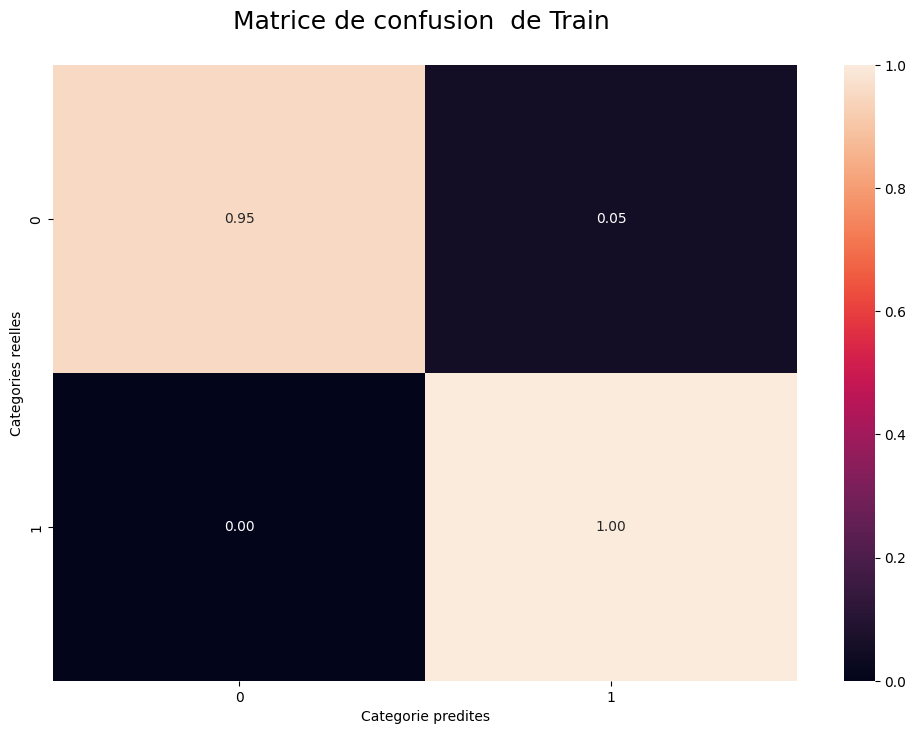

F2 score model 1 :  0.28011166885888383


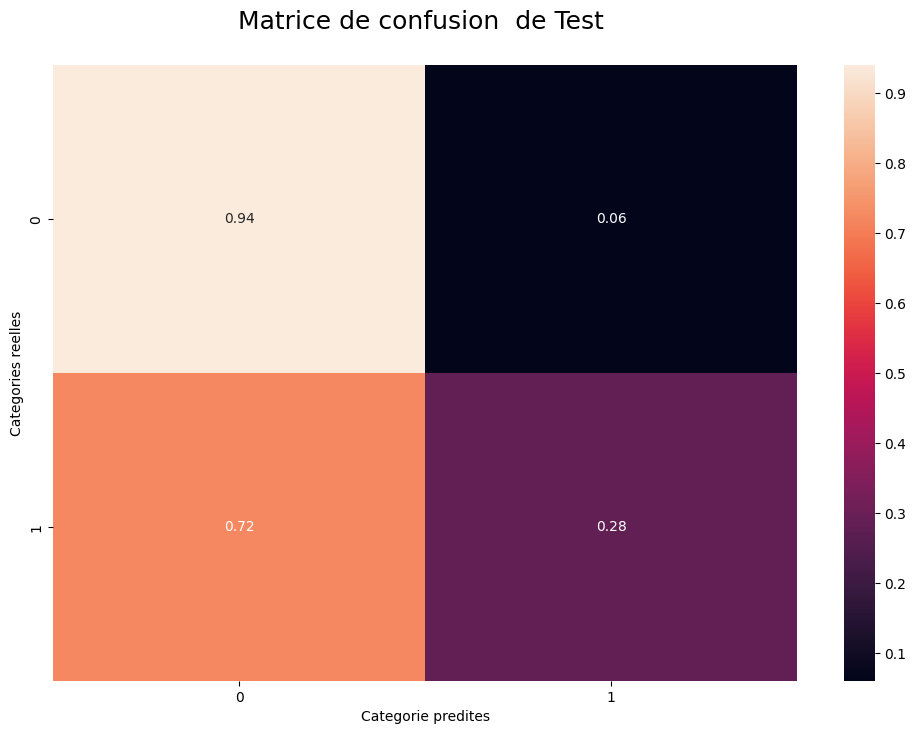

In [31]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(oversampler))
    mlflow.log_param("under-sampler", str(undersampler))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

Le modele overfit clairement. Ses resultats sont excellent en train, mais mediocre en test. L'objectif va donc etre de tuner le dataset d'entree pour parvenir a creer un model qui n'overfit pas trop.

# TEST par reduction du nombre de features

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def feature_importance_rf(xtrain, modelrf, top=True, size = 20) :
    feat_imps = pd.DataFrame()
    feat_imps['feature'] = xtrain.columns
    feat_imps['poids'] = modelrf.feature_importances_
    # feat_imps['parametres'] = [BESTTESTDESC for i in range(len(xtrain.columns))]
    if top :
        feat_imps = feat_imps.sort_values(by=['poids'], ascending=False).head(size)
    plt.figure(figsize=(14, 10))
    sns.color_palette("rocket", as_cmap=True)
    sns.barplot(x=feat_imps['poids'], y=feat_imps['feature'], orient='h', palette="rocket")
    # sns.despine(left=True, bottom=True) # Vire les axes
    plt.plot
    # Setting the label for x-axis
    plt.xlabel("FEATURES")
    # Setting the label for y-axis
    plt.ylabel("BETA_i")
    # Setting the title for the graph
    plt.title("Coefficients des features avec le Random Forest")
    plt.xticks(rotation=90)
    plt.show()
    return feat_imps

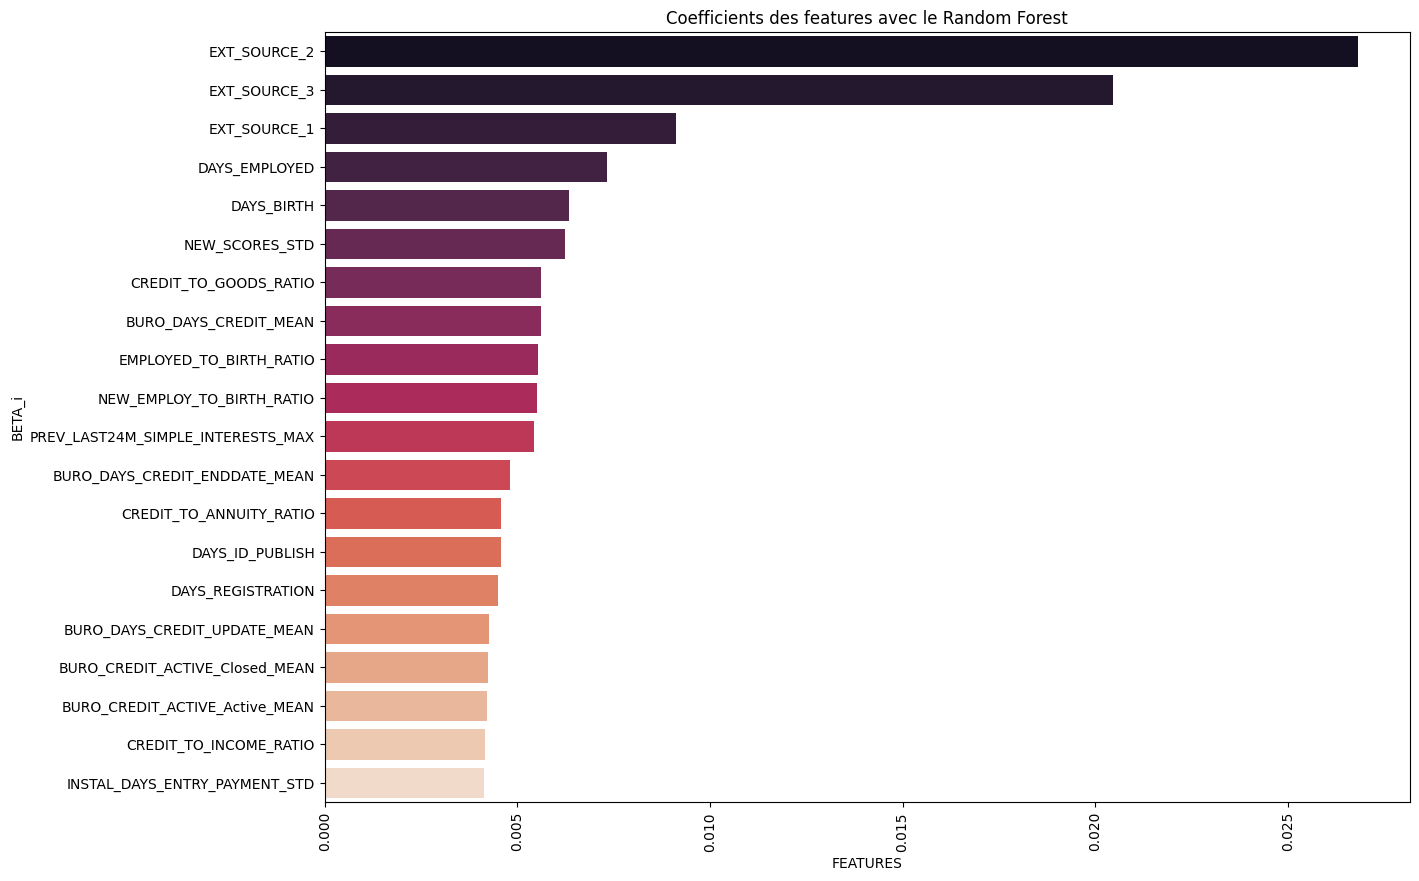

In [37]:
featimps = feature_importance_rf(xtrain=X_train, modelrf=model['estimator'], size=20)

In [41]:
light_train_df = train_df[featimps['feature'].values.tolist()]
light_train_df.shape

(307506, 20)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(light_train_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

X_train : (215254, 20) // X_test : (92252, 20)
y_train : (215254,) // y_test : (92252,)


In [43]:
model.fit(X_train, y_train)
model

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', RandomForestClassifier())])

 TRAIN F2 score model :  0.8414441635918145


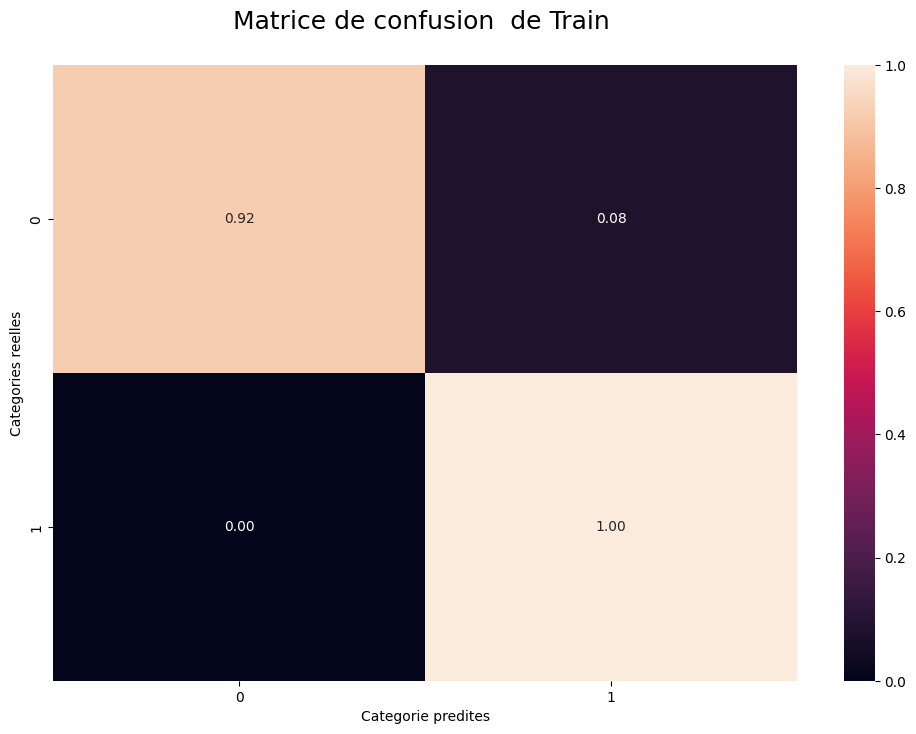

F2 score model 1 :  0.3280639129695733


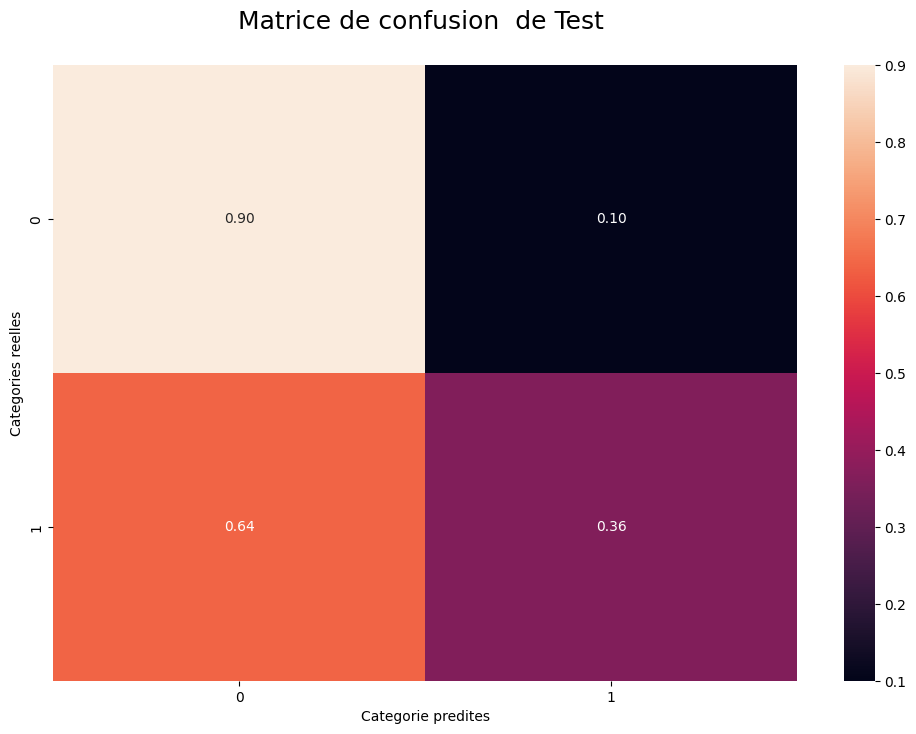

In [44]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(oversampler))
    mlflow.log_param("under-sampler", str(undersampler))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

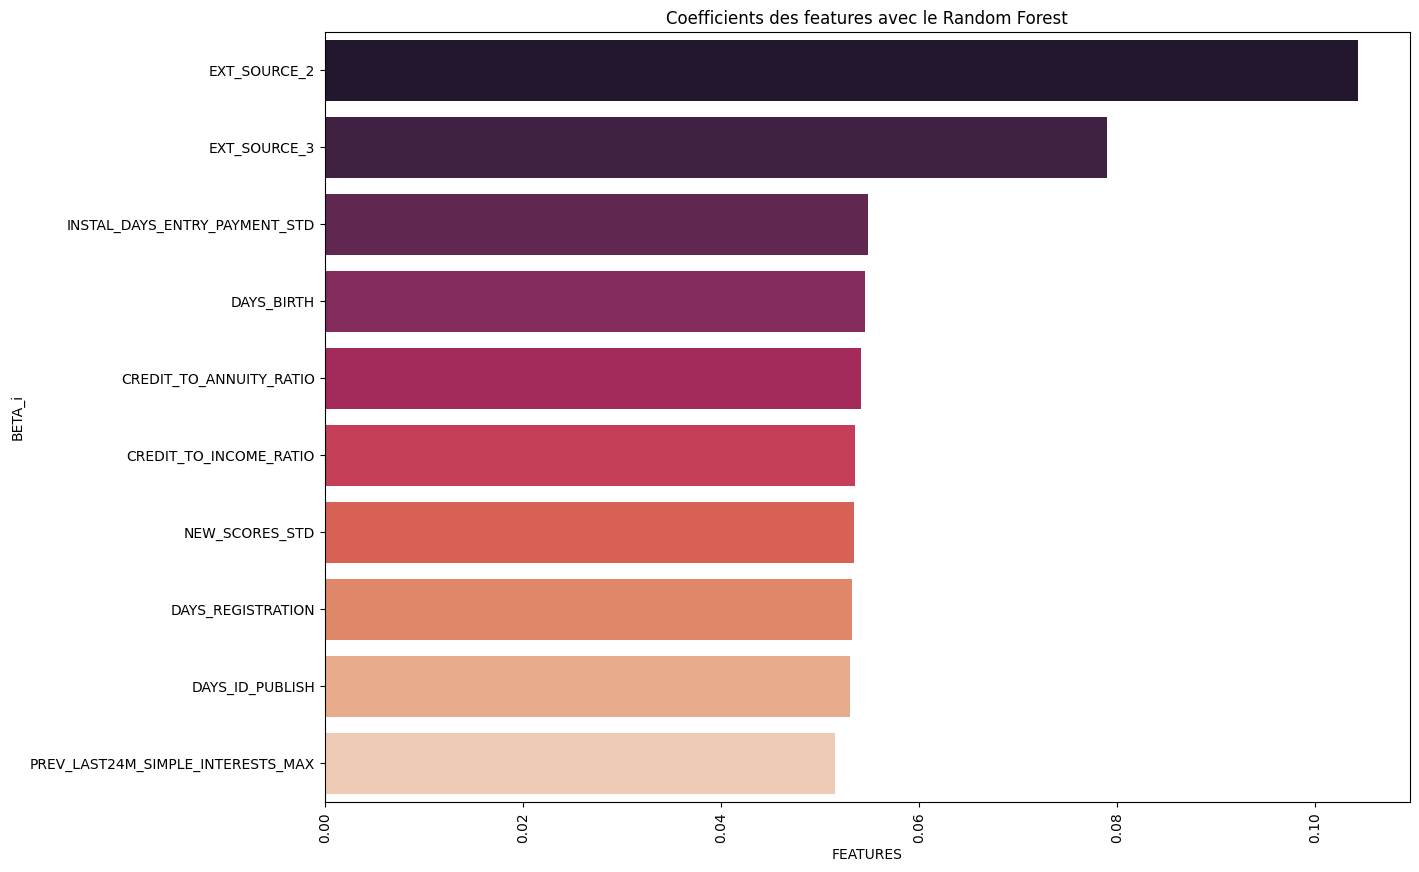

In [45]:
featimps = feature_importance_rf(xtrain=X_train, modelrf=model['estimator'], size=10)

In [46]:
light_train_df = train_df[featimps['feature'].values.tolist()]
print("Forme du dataset de Train : ", light_train_df.shape)
X_train, X_test, y_train, y_test = train_test_split(light_train_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")
model.fit(X_train, y_train)
model

Forme du dataset de Train :  (307506, 10)
X_train : (215254, 10) // X_test : (92252, 10)
y_train : (215254,) // y_test : (92252,)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', RandomForestClassifier())])

 TRAIN F2 score model :  0.8357139421920838


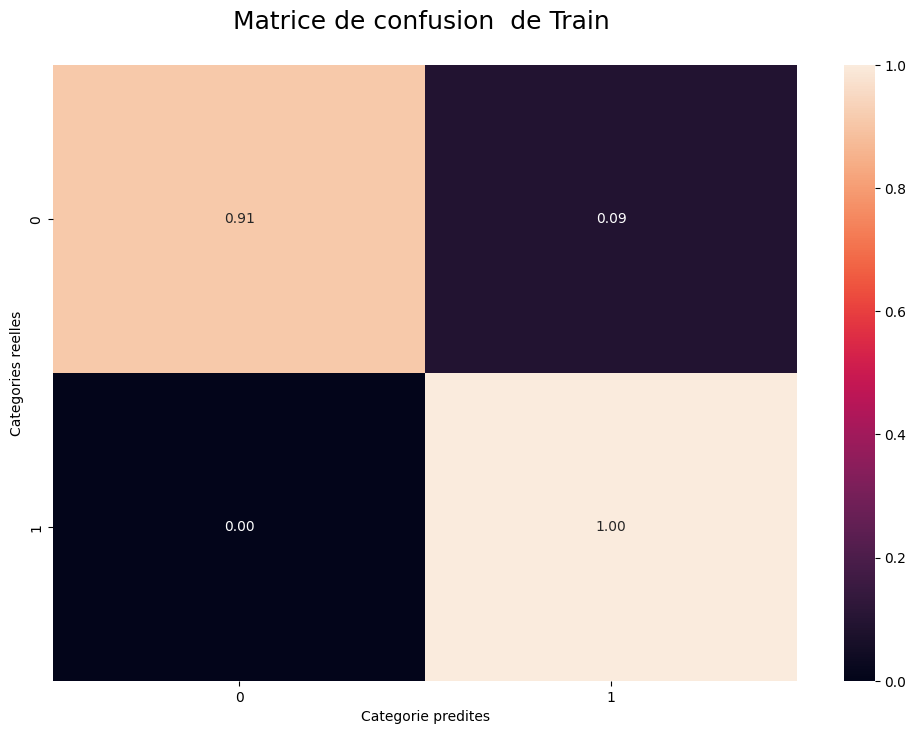

F2 score model 1 :  0.32308173980058763


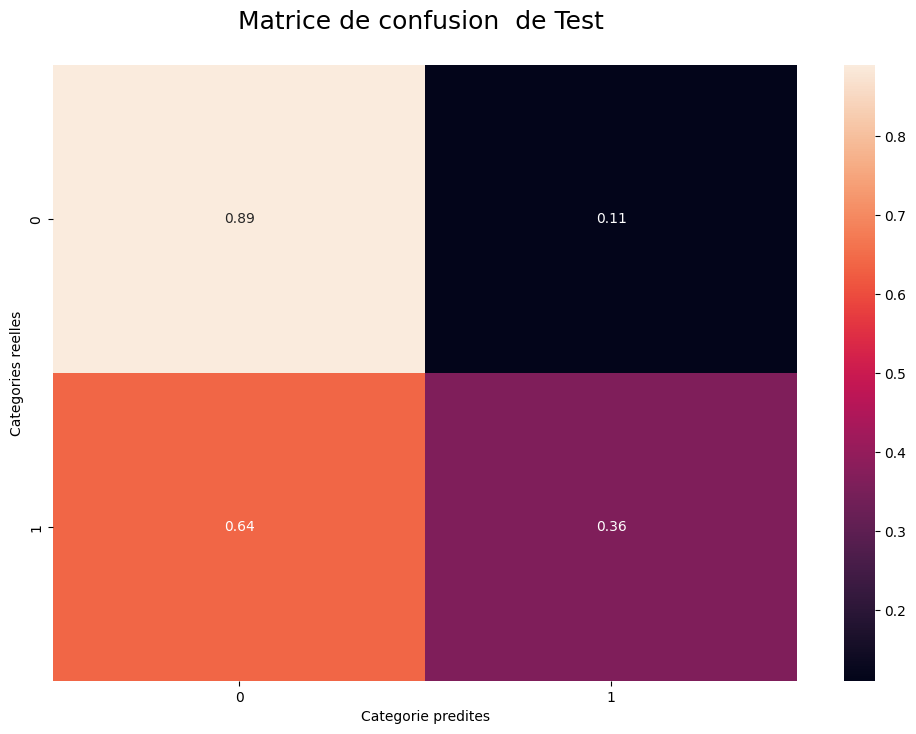

In [47]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(oversampler))
    mlflow.log_param("under-sampler", str(undersampler))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [49]:
from sklearn.inspection import permutation_importance # https://christophm.github.io/interpretable-ml-book/feature-importance.html

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

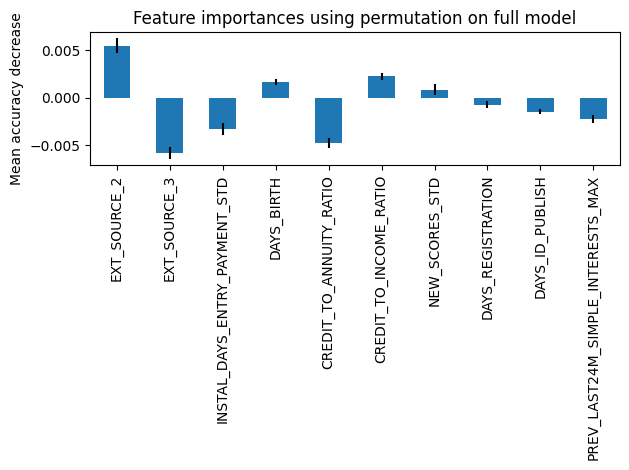

In [50]:
forest_importances = pd.Series(result.importances_mean, index=light_train_df.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Qu'on utilise les 20 features les plus importantes ou les 10, les resultats sont similaires. Le F2 s'est ameliore par rapport au model utilisant l'ensemble des features, mais on continue d'overfitter.

L'etude des feature importance semble indiquer que ceci est du principalement aux Features de type EXT-SOURCE. Or, ces features sont tres peu renseignees et peut-etre meriteraient-elles d'etre sorties du DataSet.

# TEST - Retrait des features trop peu renseignees

In [60]:
df_cleaned = ckk.remove_too_nany_columns(df, treshold=20)

Forme avant traitement :  (356250, 535)
Suppression des 226 colonnes avec plus de 20% de valeurs manquantes
Dataset sans les features vides a plus de 20% :  (356250, 309)


In [61]:
train_df = df_cleaned[df_cleaned['TARGET'].notnull()]
test_df = df_cleaned[df_cleaned['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

X = train_df.drop(columns = ['TARGET'])
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

model.fit(X_train, y_train)
model

Train shape: (307506, 309), test shape: (48744, 309)
X_train : (215254, 308) // X_test : (92252, 308)
y_train : (215254,) // y_test : (92252,)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', RandomForestClassifier())])

 TRAIN F2 score model :  0.894108567018266


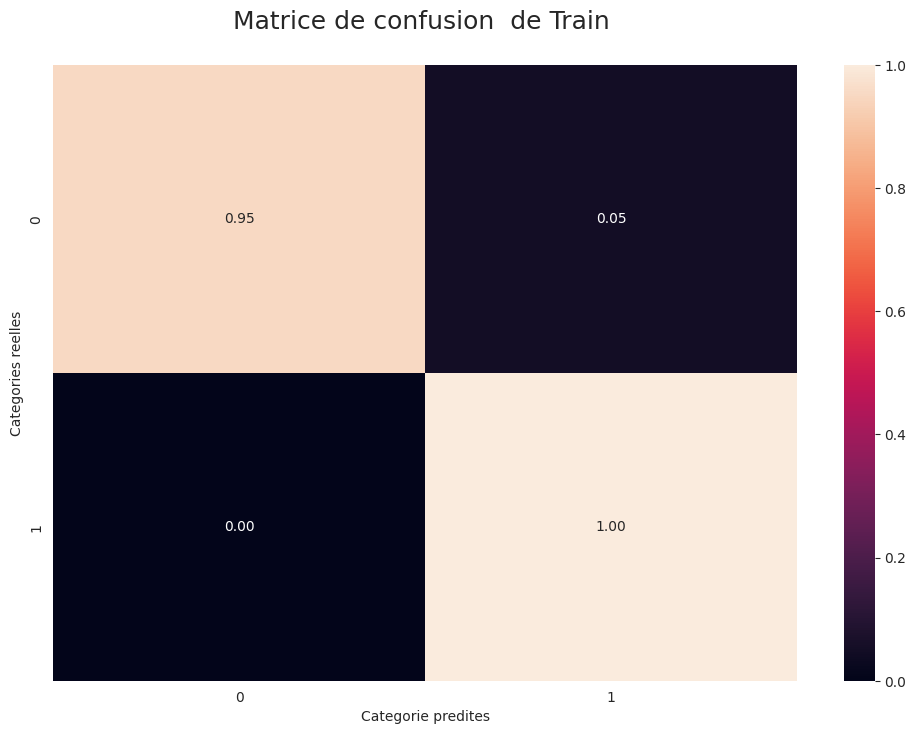

F2 score model 1 :  0.2794715447154471


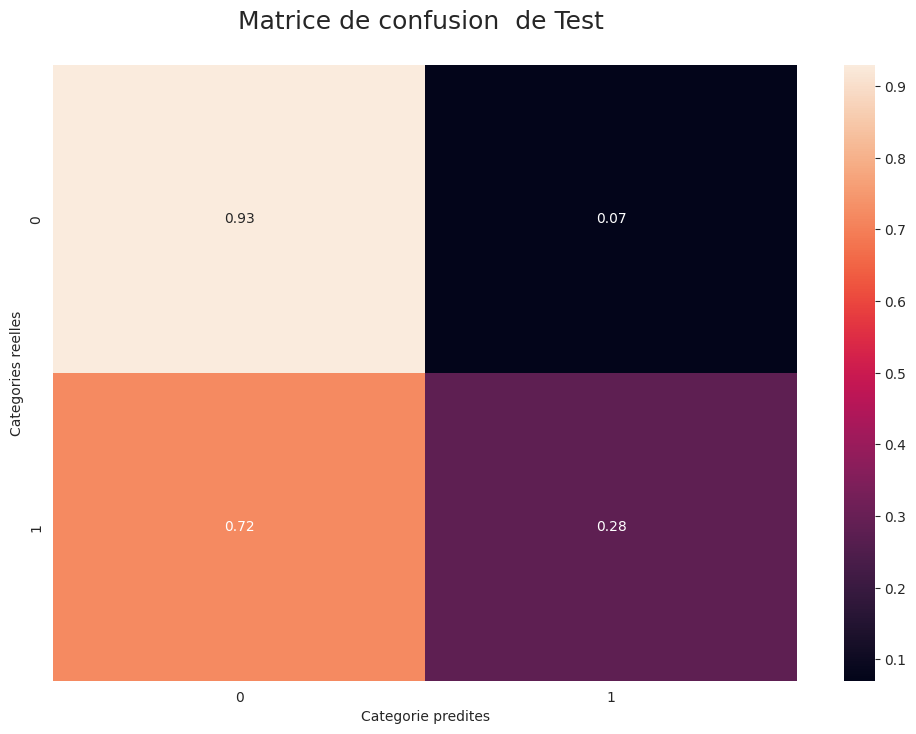

In [62]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(oversampler))
    mlflow.log_param("under-sampler", str(undersampler))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

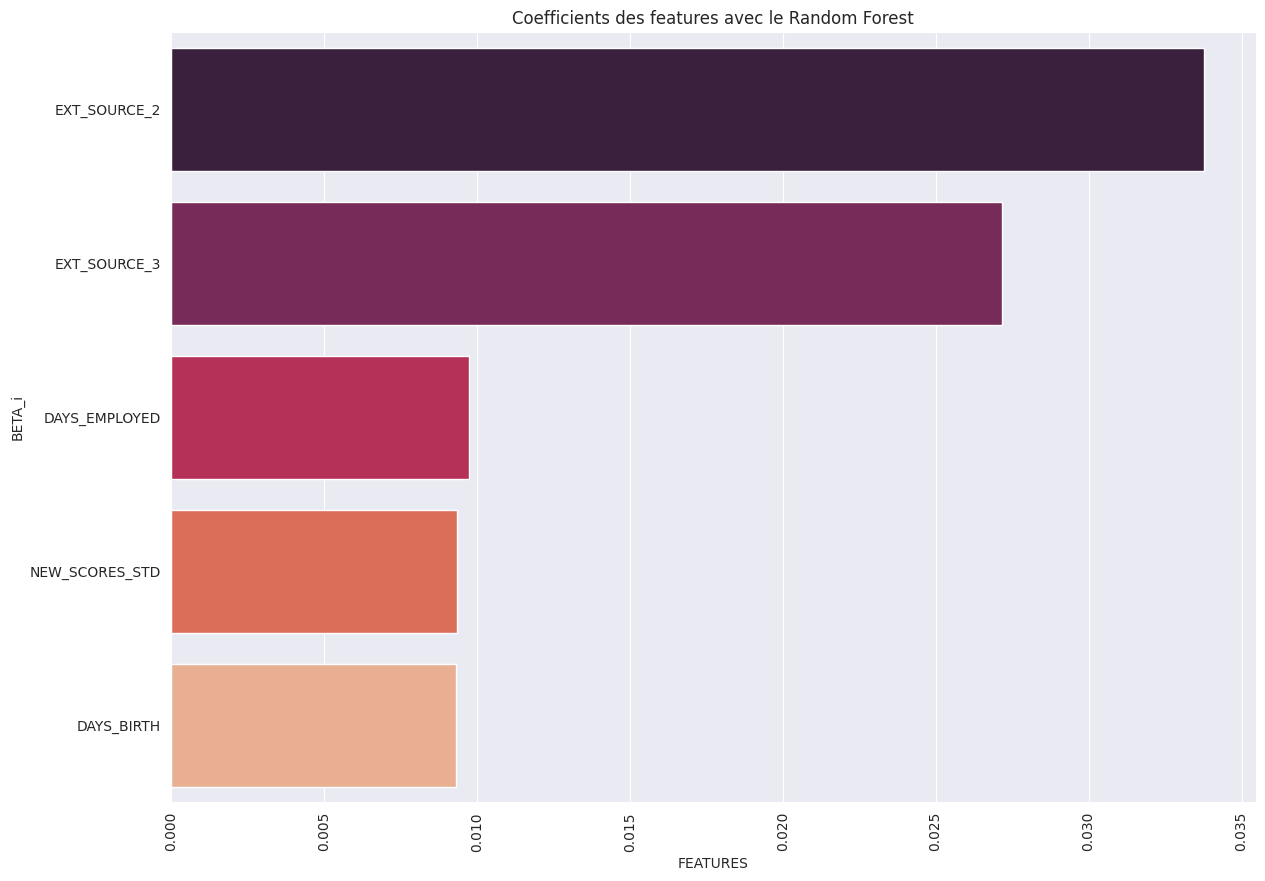

In [63]:
featimps = feature_importance_rf(xtrain=X_train, modelrf=model['estimator'], size=5)

In [57]:
light_train_df = train_df[featimps['feature'].values.tolist()]
print("Forme du dataset de Train : ", light_train_df.shape)
X_train, X_test, y_train, y_test = train_test_split(light_train_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")
model.fit(X_train, y_train)
model

Forme du dataset de Train :  (307506, 5)
X_train : (215254, 5) // X_test : (92252, 5)
y_train : (215254,) // y_test : (92252,)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', RandomForestClassifier())])

 TRAIN F2 score model :  0.8052064798339265


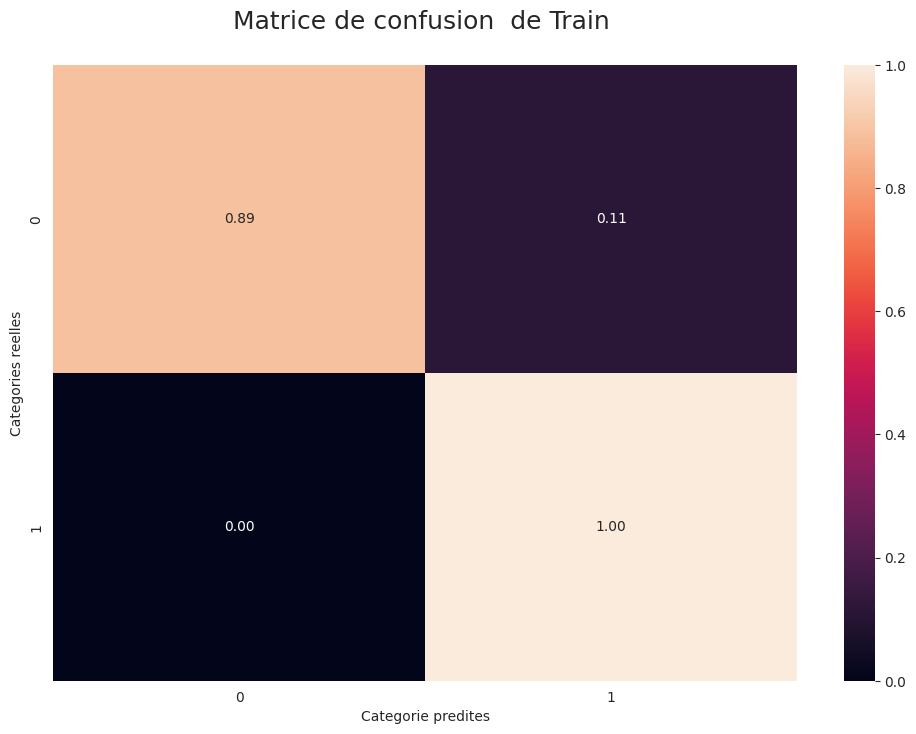

F2 score model 1 :  0.2987338281591102


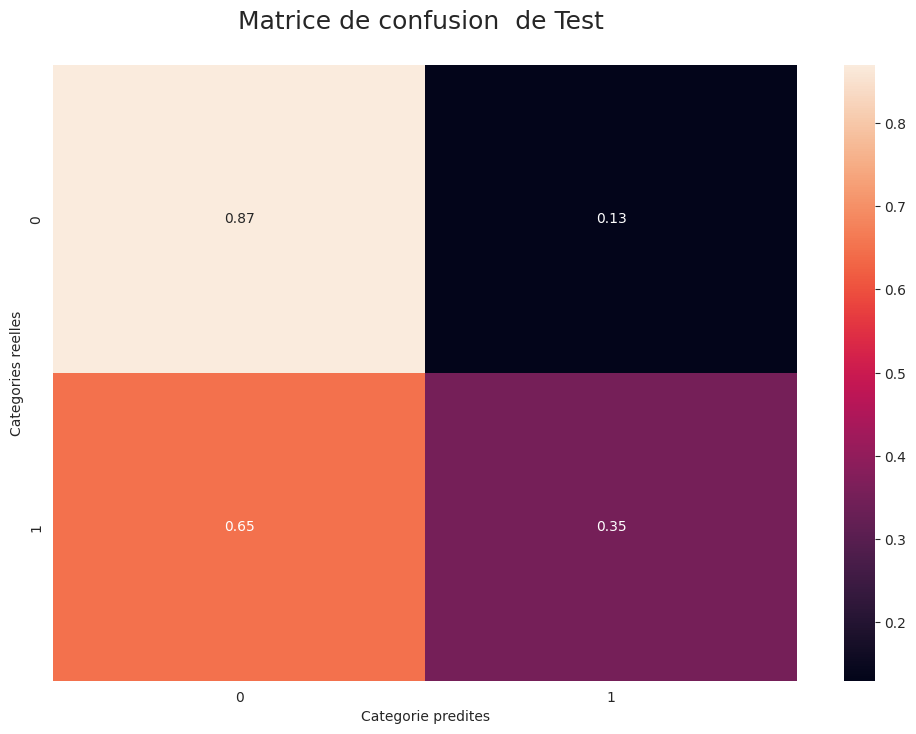

In [58]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(oversampler))
    mlflow.log_param("under-sampler", str(undersampler))
    mlflow.log_param("Top X features", light_train_df.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

# Test GridSearch sur RandomForest

In [64]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

X = train_df.drop(columns = ['TARGET'])
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Train shape: (307506, 535), test shape: (48744, 535)
X_train : (215254, 534) // X_test : (92252, 534)
y_train : (215254,) // y_test : (92252,)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', RandomForestClassifier())])

In [65]:
over = SMOTE(random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE) # {'over__sampling_strategy': 0.1, 'under__sampling_strategy': 0.5} voir GridSearch_LogReg_Over-UnderSampling

# mlflow.log_params({"DS" : "Only AppTrain, keep NaN cols"})
mlflow.autolog() # Toggle the autolog to activate/deactivate MLFLow

estimator = RandomForestClassifier(n_estimators =  100, max_depth=15, class_weight='balanced') #


# Parametres Random Forest
params = {
    'over__sampling_strategy' : [0.1, 0.3],
    'estimator__min_samples_split' : [20, 50, 100]
}

pipeline = Pipeline(
    [
        ("imputer", s_imputer),
        ("scaler", mm_scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

2023/05/27 20:51:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/05/27 20:51:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0c16c6003779401998b7eddc2ebe33de', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/27 21:31:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/maximorose/anaconda3/envs/oc_ds_p7/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/05/27 21:31:50 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('over', SMOTE(random_state=42)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=15))]),
             param_grid={'estimator__min_samples_split': [20, 50, 100],
                         'over__sampling_strategy': [0.1, 0.3]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [66]:
model.best_params_

{'estimator__min_samples_split': 100, 'over__sampling_strategy': 0.1}

In [9]:
def grid_resultification(grid) :
    res = pd.DataFrame(grid.cv_results_)
    keepcols = [col for col in res.columns if "split" not in col]
    res = res[keepcols]
    # res = res.sort_values(by = ['rank_test_r2', 'rank_test_neg_mean_absolute_error'])
    return res

df_results_grid = grid_resultification(model)
df_results_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_over__sampling_strategy,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,131.496940,1.979606,0.588701,0.008602,0.1,"{'estimator__min_samples_split': 100, 'over__s...",0.352079,0.010116,3,0.685529,0.002618
1,209.463943,2.616341,0.588976,0.006604,0.5,"{'estimator__min_samples_split': 100, 'over__s...",0.107118,0.006528,6,0.271972,0.005452
2,311.858234,4.043446,0.585346,0.006468,1.0,"{'estimator__min_samples_split': 100, 'over__s...",0.065210,0.007428,9,0.154951,0.004441
3,117.153830,1.520025,0.504312,0.006014,0.1,"{'estimator__min_samples_split': 500, 'over__s...",0.411254,0.009112,2,0.534293,0.001948
4,188.750137,1.993547,0.509672,0.005418,0.5,"{'estimator__min_samples_split': 500, 'over__s...",0.130869,0.007426,5,0.182424,0.003697
5,288.620228,3.124842,0.514237,0.003046,1.0,"{'estimator__min_samples_split': 500, 'over__s...",0.073513,0.006054,8,0.101798,0.003658
6,105.733413,0.383250,0.445098,0.001805,0.1,"{'estimator__min_samples_split': 1000, 'over__...",0.419430,0.008890,1,0.486239,0.001425
7,172.622709,2.986788,0.448297,0.005271,0.5,"{'estimator__min_samples_split': 1000, 'over__...",0.141427,0.006549,4,0.170004,0.005043
8,271.048998,2.704652,0.455800,0.005562,1.0,"{'estimator__min_samples_split': 1000, 'over__...",0.079569,0.007285,7,0.096612,0.004168


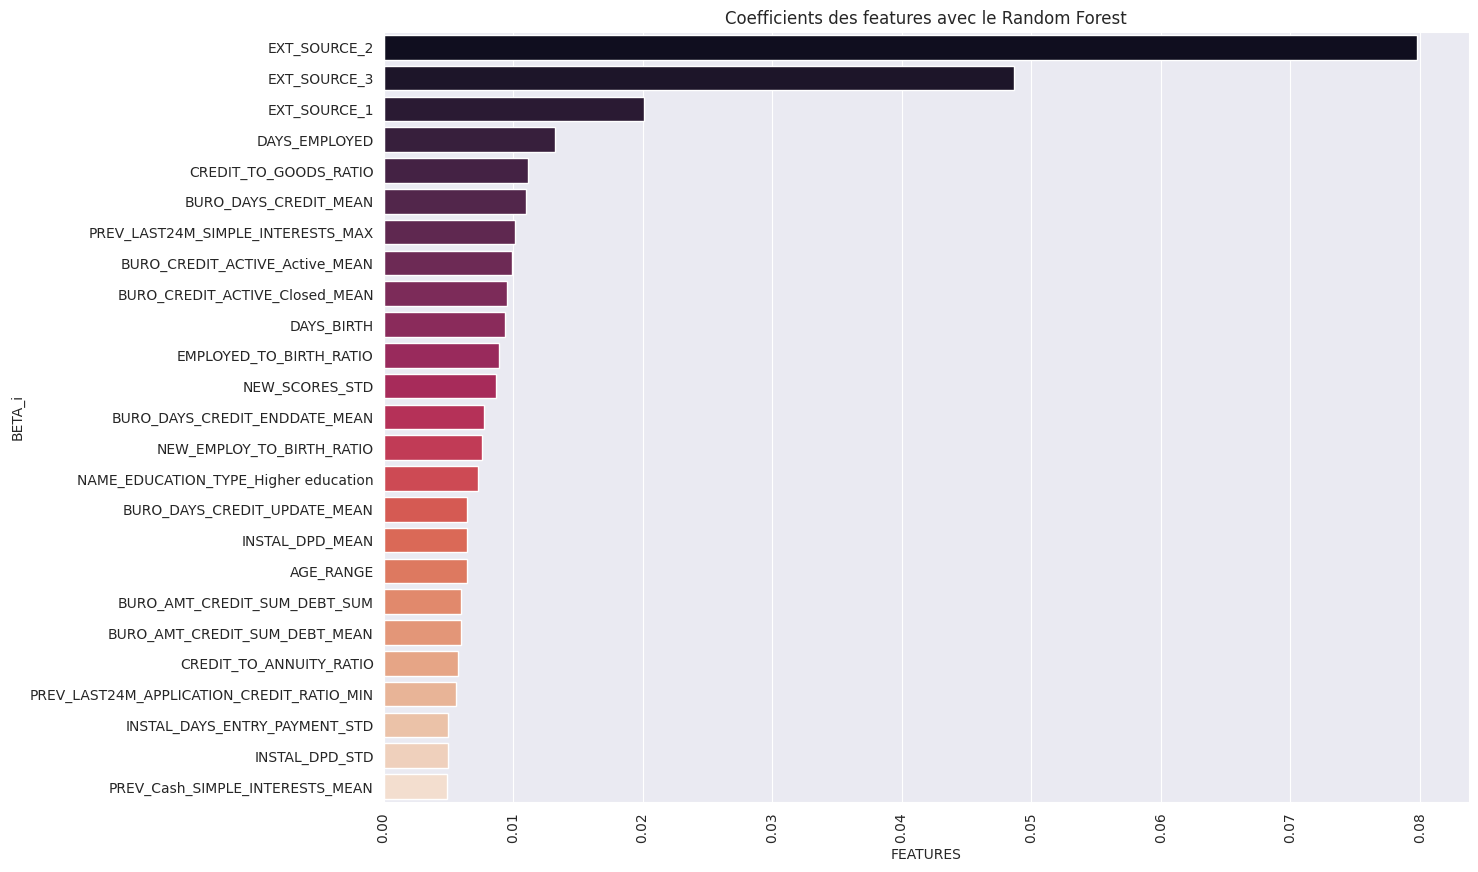

In [71]:
featimps = feature_importance_rf(xtrain=X_train, modelrf=model.best_estimator_['estimator'], size=25)

In [72]:
be = model.best_estimator_
be.fit(X_train, y_train)

2023/05/27 22:18:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '082c955fb0d442e696f2341aef9f516f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/27 22:18:31 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/05/27 22:18:31 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/05/27 22:18:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/05/27 22:18:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd33d6d3aff6d4ea784f8497b0f06a820', which will track hyperparameters, performance metrics, model artifacts, 

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=100))])

light_train_df = train_df[featimps['feature'].values.tolist()]

 TRAIN F2 score model :  0.5468313177947824


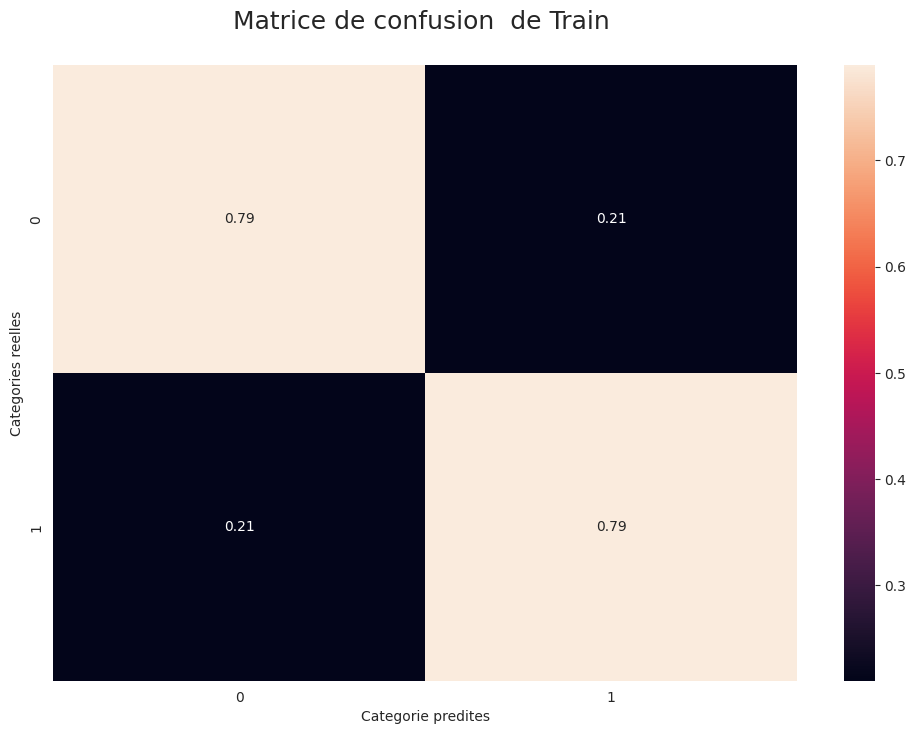

F2 score model 1 :  0.41296774918530166


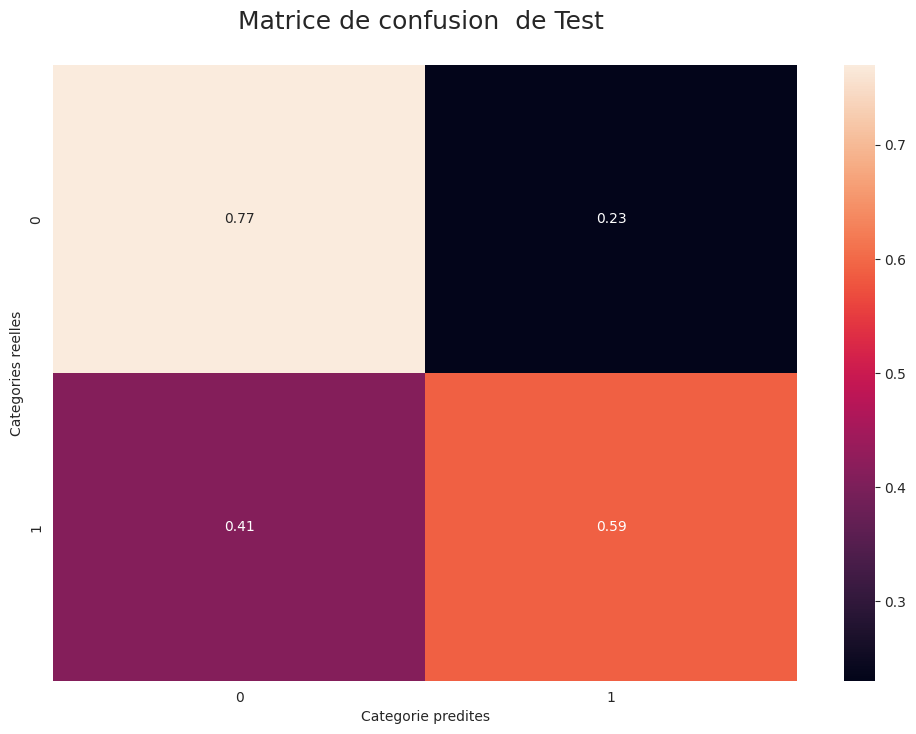

In [73]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", str(be['under']))
    mlflow.log_param("Top X features", df.shape[1])
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

On overfit encore un peu. Mais ca s'est bien ameliorer. C'est clairement sur le min_sample qu'il fallait travailler. Peut-etre tester des valeurs superieures.
Tester aussi avec class_weight.


## On test avec moins de feature
Pour avoir des performances opti

In [74]:
light_train_df = train_df[featimps['feature'].values.tolist()]
print("Forme du dataset de Train : ", light_train_df.shape)
X_train, X_test, y_train, y_test = train_test_split(light_train_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")
be.fit(X_train, y_train)
be

Forme du dataset de Train :  (307506, 25)
X_train : (215254, 25) // X_test : (92252, 25)
y_train : (215254,) // y_test : (92252,)


2023/05/27 22:24:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '56041cfa3aec4fa5a9144d48e297b4e9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/27 22:24:39 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/05/27 22:24:39 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/05/27 22:24:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/05/27 22:24:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0e6afa608383465a9ac9e51b17583c5a', which will track hyperparameters, performance metrics, model artifacts, 

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=100))])

 TRAIN F2 score model :  0.483704974271012


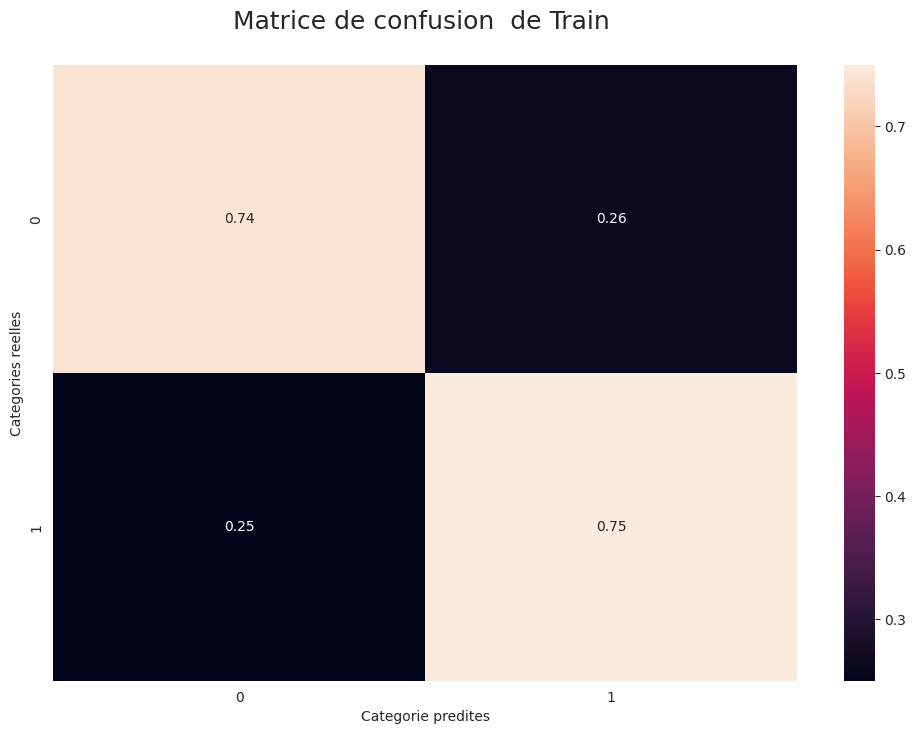

F2 score model 1 :  0.4158522965238029


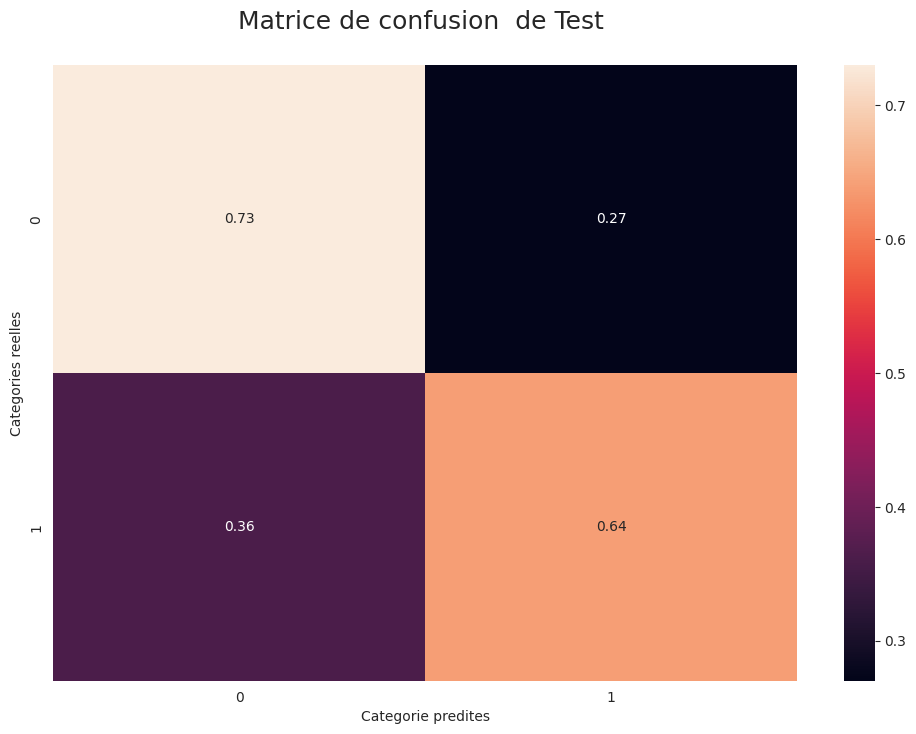

In [75]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", str(be['under']))
    mlflow.log_param("Top X features", df.shape[1])
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

Ca s'ameliore !!

On va encore pousser un peu le GridSearch

# More Options

In [76]:
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE) # {'over__sampling_strategy': 0.1, 'under__sampling_strategy': 0.5} voir GridSearch_LogReg_Over-UnderSampling

# mlflow.log_params({"DS" : "Only AppTrain, keep NaN cols"})
mlflow.autolog() # Toggle the autolog to activate/deactivate MLFLow

estimator = RandomForestClassifier(n_estimators =  100, max_depth=15, class_weight='balanced') #


# Parametres Random Forest
params = {
    'estimator__min_samples_split' : [100, 500, 1000],
}

pipeline = Pipeline(
    [
        ("imputer", s_imputer),
        ("scaler", mm_scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

2023/05/27 22:29:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/05/27 22:29:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9e72a158003e484597ecd0b2703d3650', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/27 22:32:22 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=15))]),
             param_grid={'estimator__min_samples_split': [100, 500, 1000]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [77]:
model.best_params_

{'estimator__min_samples_split': 100}

In [78]:
light_train_df = train_df[featimps['feature'].values.tolist()]
print("Forme du dataset de Train : ", light_train_df.shape)
X_train, X_test, y_train, y_test = train_test_split(light_train_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Forme du dataset de Train :  (307506, 25)
X_train : (215254, 25) // X_test : (92252, 25)
y_train : (215254,) // y_test : (92252,)


In [79]:
estimator = RandomForestClassifier(n_estimators =  100, max_depth=15, class_weight='balanced') #


# Parametres Random Forest
params = {
    'estimator__min_samples_split' : [80, 100, 200],
}

pipeline = Pipeline(
    [
        ("imputer", s_imputer),
        ("scaler", mm_scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

2023/05/27 22:36:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a540abf07aa44d2ab40843ed90ddbe6a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/27 22:40:18 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=15))]),
             param_grid={'estimator__min_samples_split': [80, 100, 200]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [80]:
model.best_params_

{'estimator__min_samples_split': 80}

In [82]:
be = model.best_estimator_
be.fit(X_train, y_train)

2023/05/27 22:41:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5b72b9ea61b4483e93ba12b863a6fde0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/27 22:41:26 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/05/27 22:41:26 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/05/27 22:41:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/05/27 22:41:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c2481d6957df4bfa9b790ad921ecc7b2', which will track hyperparameters, performance metrics, model artifacts, 

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=80))])

 TRAIN F2 score model :  0.49553628700580316


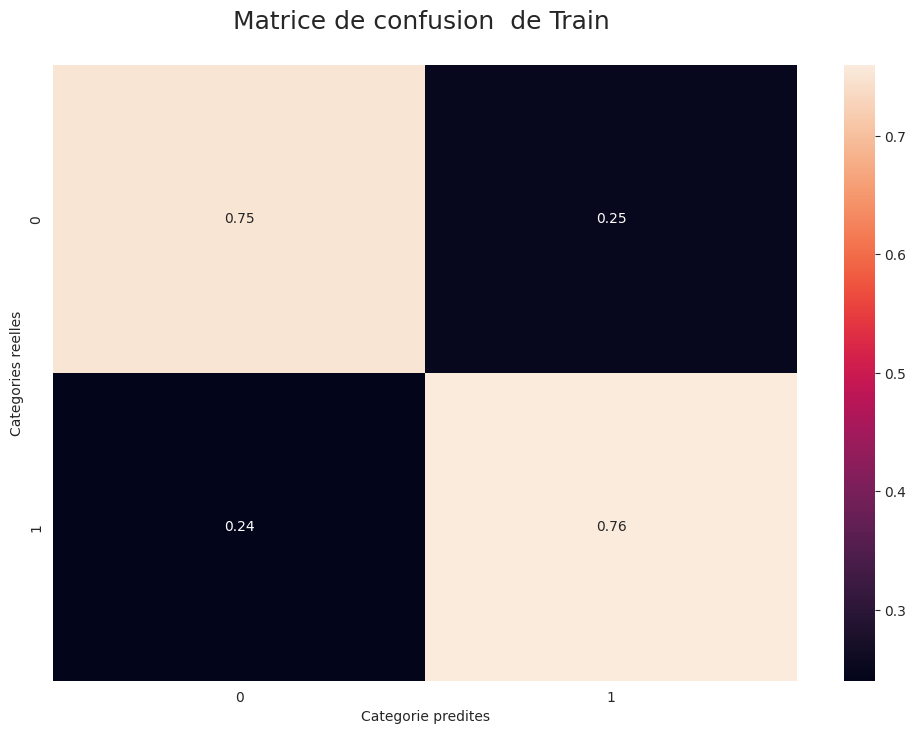

F2 score model 1 :  0.4151096382993725


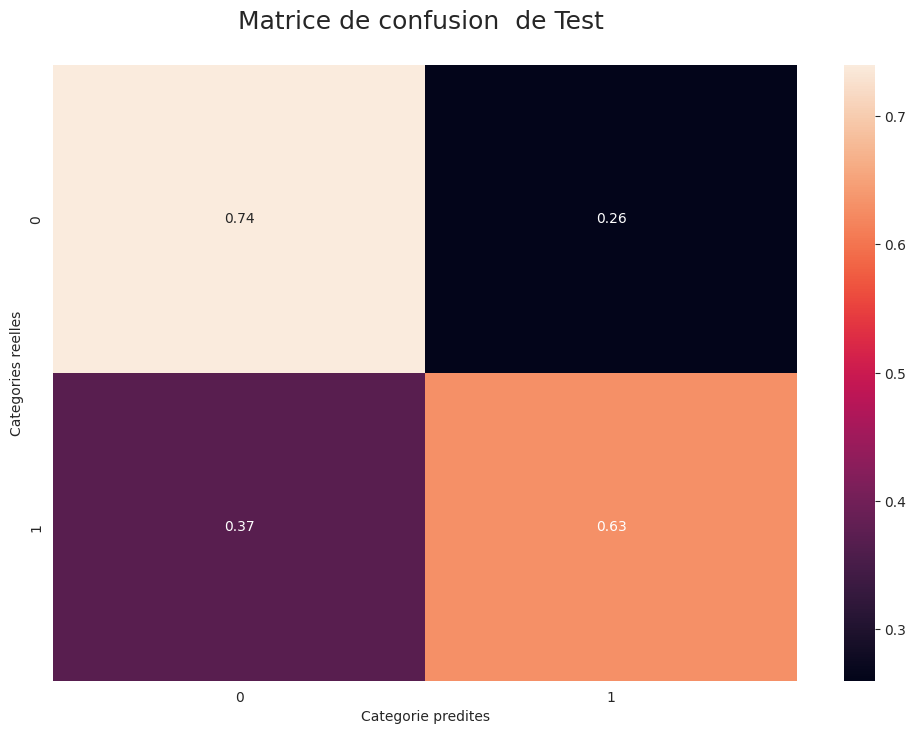

In [83]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", str(be['under']))
    mlflow.log_param("Top X features", df.shape[1])
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [95]:
X = train_df.drop(columns = ['TARGET'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

X_train : (215254, 534) // X_test : (92252, 534)
y_train : (215254,) // y_test : (92252,)


In [98]:
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier(n_estimators =  100, max_depth=15, class_weight='balanced', min_samples_split=100) #


# Parametres Random Forest
params = {
    'estimator__max_features' : [15, 'sqrt', 'log2'],
}

pipeline = Pipeline(
    [
        ("imputer", s_imputer),
        ("scaler", mm_scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

2023/05/28 01:29:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5af27c43d705479cb3137892a0f351ec', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/28 01:38:29 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=15,
                                                               min_samples_split=100))]),
             param_grid={'estimator__max_features': [15, 'sqrt', 'log2']},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [99]:
model.best_params_

{'estimator__max_features': 'sqrt'}

BEST ESTIMATOR SO FAR : n_estimators =  100, max_depth=15, class_weight='balanced', min_samples_split=100, max_features='sqrt'

In [7]:
over = SMOTE(random_state=RANDOM_STATE)
estimator = RandomForestClassifier(n_estimators =  100, max_depth=15, class_weight='balanced', max_features='sqrt') #


# Parametres Random Forest
params = {
    'estimator__min_samples_split' : [100, 500, 1000],
    'over__sampling_strategy' : [0.1, 0.5, 1.0]
}

pipeline = Pipeline(
    [
        ("imputer", s_imputer),
        ("scaler", mm_scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        # ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=10)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('over', SMOTE(random_state=42)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=15))]),
             param_grid={'estimator__min_samples_split': [100, 500, 1000],
                         'over__sampling_strategy': [0.1, 0.5, 1.0]},
             return_train_score=True, scoring=make_scorer(custom_metric))

TODO
- Tester de croiser min_sample et over sampling.
- Essayer de ne pas faire d'under-sampling
- Essayer de croiser max-depth et min-sample-split

In [10]:
df_results_grid = grid_resultification(model)
df_results_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_over__sampling_strategy,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,131.496940,1.979606,0.588701,0.008602,0.1,"{'estimator__min_samples_split': 100, 'over__s...",0.352079,0.010116,3,0.685529,0.002618
1,209.463943,2.616341,0.588976,0.006604,0.5,"{'estimator__min_samples_split': 100, 'over__s...",0.107118,0.006528,6,0.271972,0.005452
2,311.858234,4.043446,0.585346,0.006468,1.0,"{'estimator__min_samples_split': 100, 'over__s...",0.065210,0.007428,9,0.154951,0.004441
3,117.153830,1.520025,0.504312,0.006014,0.1,"{'estimator__min_samples_split': 500, 'over__s...",0.411254,0.009112,2,0.534293,0.001948
4,188.750137,1.993547,0.509672,0.005418,0.5,"{'estimator__min_samples_split': 500, 'over__s...",0.130869,0.007426,5,0.182424,0.003697
5,288.620228,3.124842,0.514237,0.003046,1.0,"{'estimator__min_samples_split': 500, 'over__s...",0.073513,0.006054,8,0.101798,0.003658
6,105.733413,0.383250,0.445098,0.001805,0.1,"{'estimator__min_samples_split': 1000, 'over__...",0.419430,0.008890,1,0.486239,0.001425
7,172.622709,2.986788,0.448297,0.005271,0.5,"{'estimator__min_samples_split': 1000, 'over__...",0.141427,0.006549,4,0.170004,0.005043
8,271.048998,2.704652,0.455800,0.005562,1.0,"{'estimator__min_samples_split': 1000, 'over__...",0.079569,0.007285,7,0.096612,0.004168


In [12]:
model.best_params_

{'estimator__min_samples_split': 1000, 'over__sampling_strategy': 0.1}

 TRAIN F2 score model :  0.48784791661765053


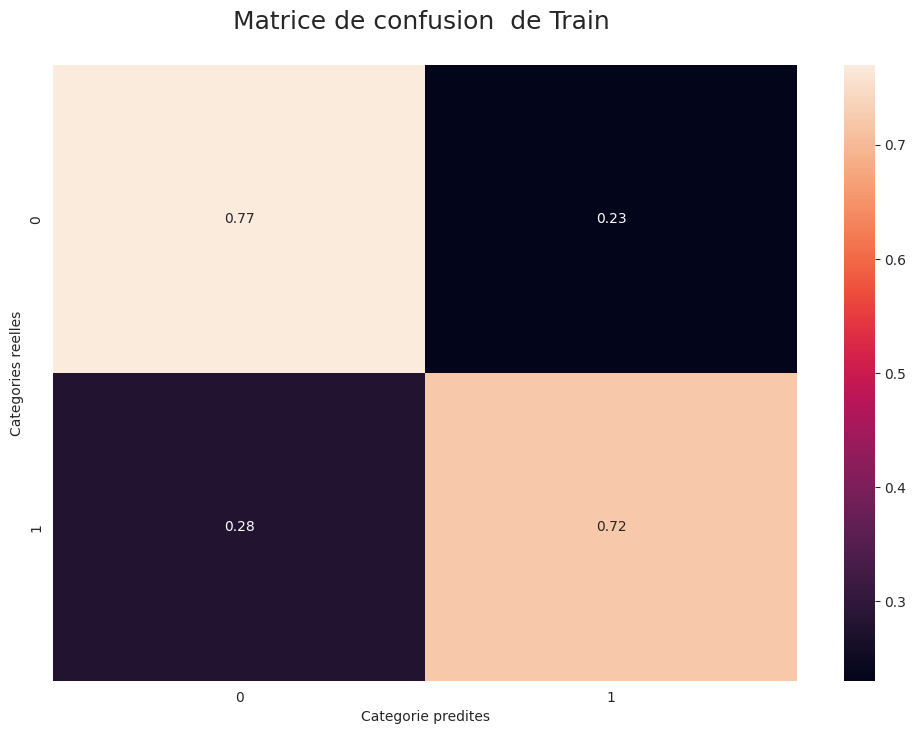

F2 score model 1 :  0.4162986678442629


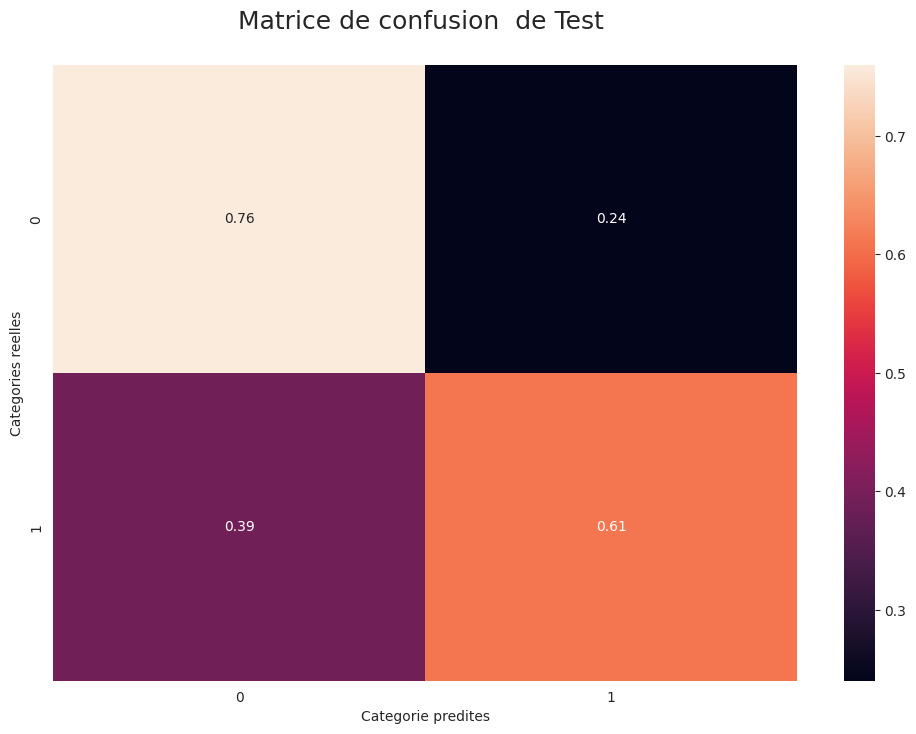

In [13]:
be = model.best_estimator_

with mlflow.start_run():
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", "") # str(be['under'])
    mlflow.log_param("Top X features", df.shape[1])
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

Sans faire d'under-sampling j'ai un overfit qui semble meme s'appliquer en test

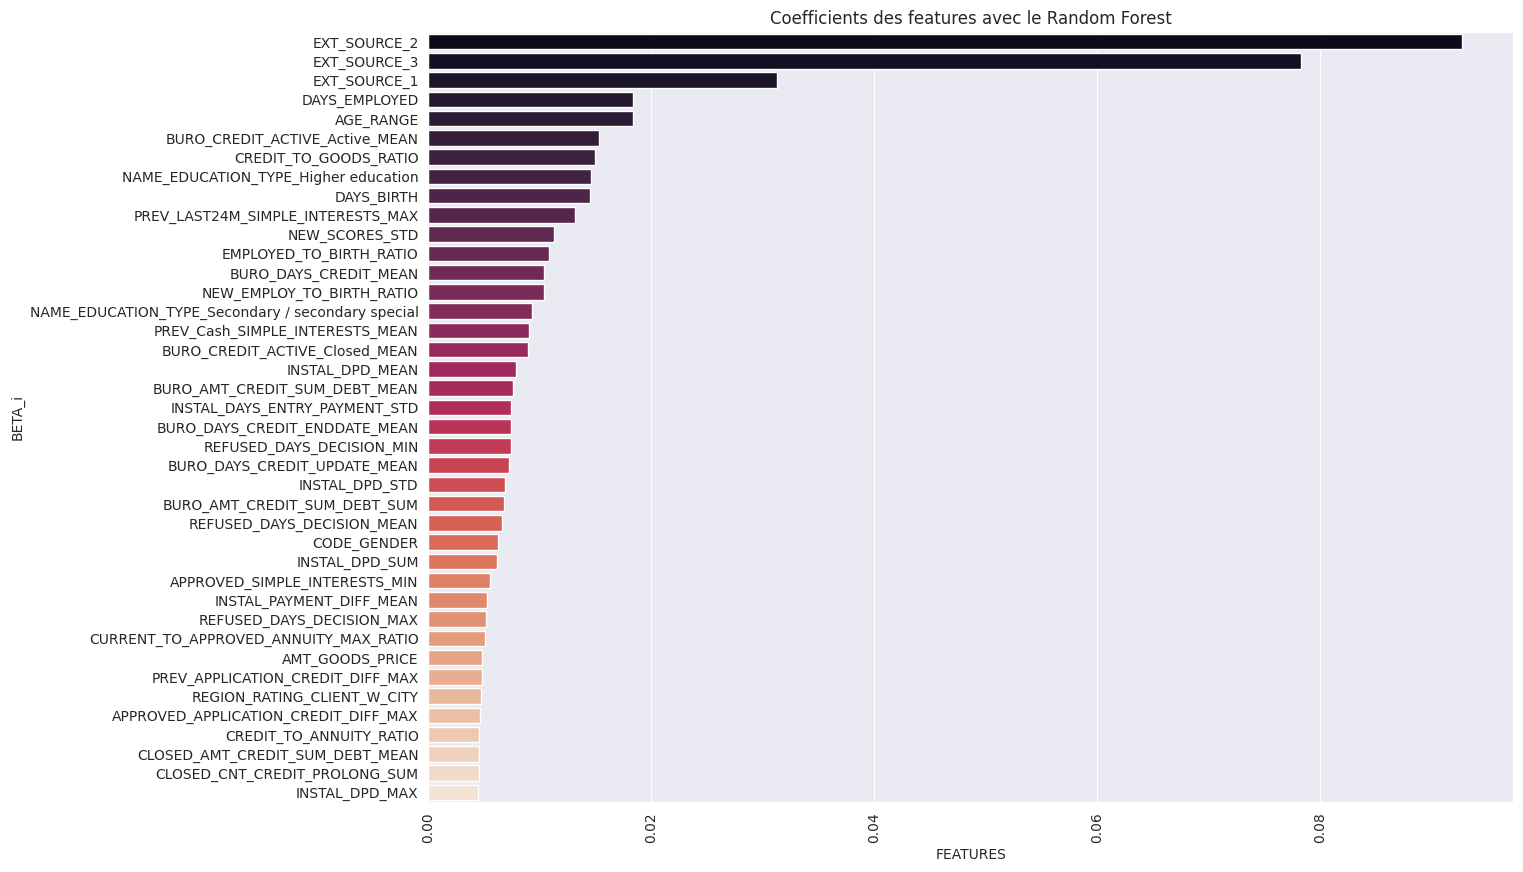

In [17]:
featimps = feature_importance_rf(xtrain=X_train, modelrf=model.best_estimator_['estimator'], size=40)

On va remettre de l'undersampling et reduire le nombre de features, de maniere a reduire le temps de traitement.

Puis on va faire un GridSearch sur min_sample & max_depth

In [19]:
light_train_df = train_df[featimps['feature'].values.tolist()]
print("Forme du dataset de Train : ", light_train_df.shape)
X_train, X_test, y_train, y_test = train_test_split(light_train_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Forme du dataset de Train :  (307506, 40)
X_train : (215254, 40) // X_test : (92252, 40)
y_train : (215254,) // y_test : (92252,)


In [21]:
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier(n_estimators =  100, class_weight='balanced', max_features='sqrt') #


# Parametres Random Forest
params = {
    'estimator__min_samples_split' : [100, 500, 1000],
    'estimator__max_depth' : [15, 25, 30, 50]
}

pipeline = Pipeline(
    [
        ("imputer", s_imputer),
        ("scaler", mm_scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=10)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'estimator__max_depth': [15, 25, 30, 50],
                         'estimator__min_samples_split': [100, 500, 1000]},
             return_train_score=True, scoring=make_scorer(custom_metric))

# VALEUR UNDERSAMPLING
- Avec undersampling
- 6 params Vs. 7 params

= 21 minutes pour le GridSearch, Versus 5h

In [22]:
model.best_params_

{'estimator__max_depth': 25, 'estimator__min_samples_split': 100}

 TRAIN F2 score model :  0.508944742050604


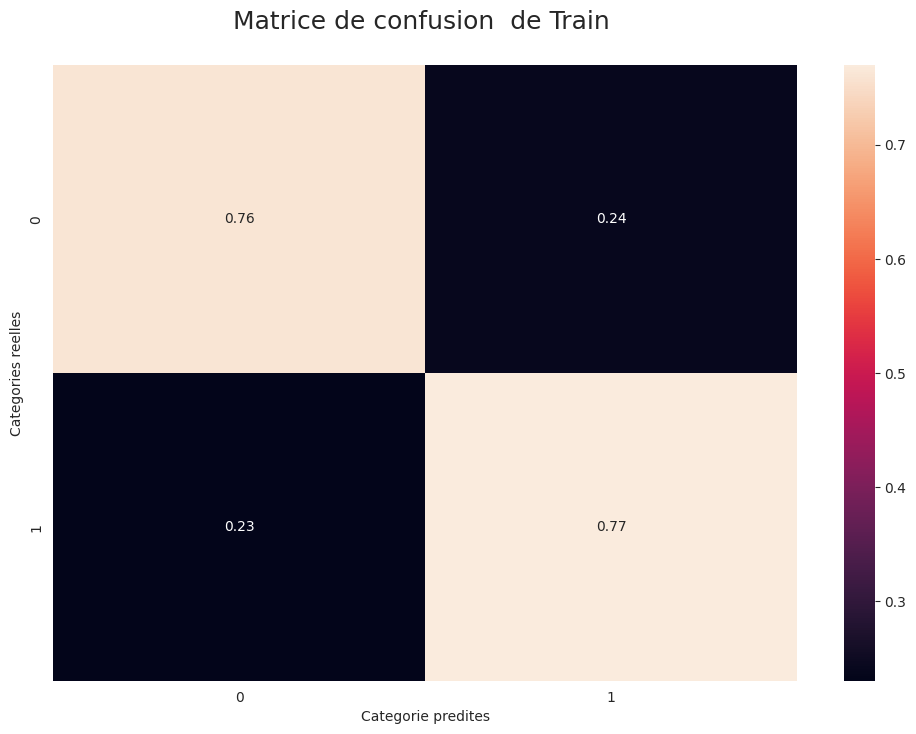

F2 score model 1 :  0.41942289126470483


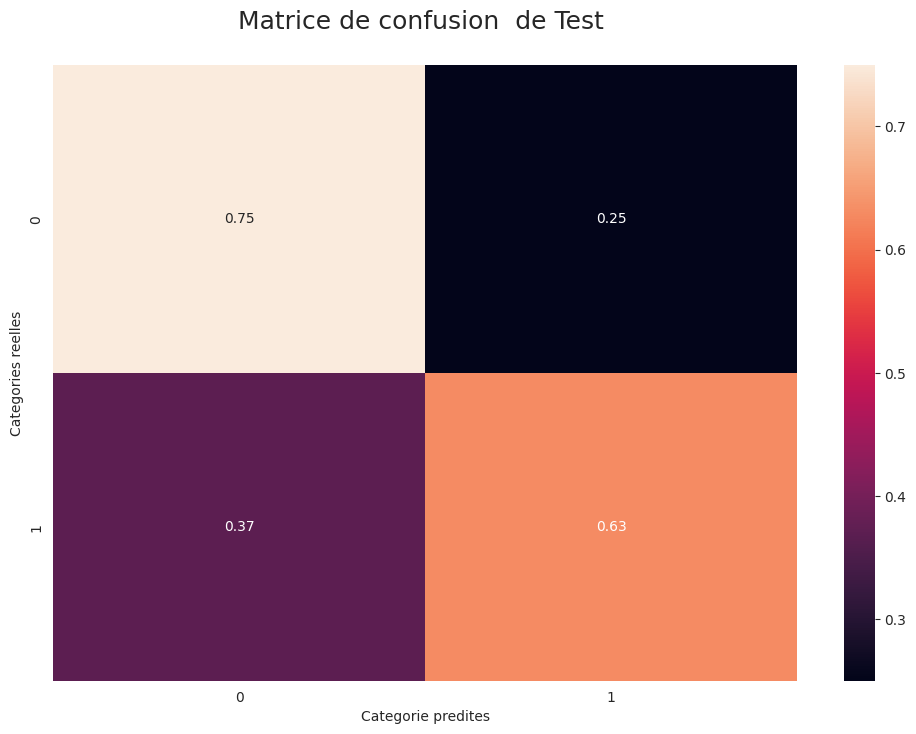

In [23]:
be = model.best_estimator_

with mlflow.start_run():
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", "") # str(be['under'])
    mlflow.log_param("Top X features", df.shape[1])
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [24]:
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier(min_samples_split =  100, max_features='sqrt') #


# Parametres Random Forest
params = {
    'estimator__n_estimators' : [100, 150, 200],
    'estimator__max_depth' : [15, 25, 50],
    'estimator__class_weight' : ['balanced', 'balanced_subsample']
}

pipeline = Pipeline(
    [
        ("imputer", s_imputer),
        ("scaler", mm_scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(min_samples_split=100))]),
             param_grid={'estimator__class_weight': ['balanced',
                                                     'balanced_subsample'],
                         'estimator__max_depth': [15, 25, 50],
                         'estimator__n_estimators': [100, 150, 200]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [25]:
model.best_params_

{'estimator__class_weight': 'balanced',
 'estimator__max_depth': 15,
 'estimator__n_estimators': 200}

In [26]:
df_results_grid = grid_resultification(model)
df_results_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__class_weight,param_estimator__max_depth,param_estimator__n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,10.185741,0.195261,0.504364,0.018287,balanced,15,100,"{'estimator__class_weight': 'balanced', 'estim...",0.419584,0.005863,10,0.498105,0.001732
1,14.565813,0.134595,0.729508,0.002892,balanced,15,150,"{'estimator__class_weight': 'balanced', 'estim...",0.419026,0.004361,14,0.499049,0.001436
2,19.051197,0.159561,0.952590,0.004860,balanced,15,200,"{'estimator__class_weight': 'balanced', 'estim...",0.420853,0.005279,1,0.499403,0.001725
3,11.643568,0.969848,0.546162,0.040616,balanced,25,100,"{'estimator__class_weight': 'balanced', 'estim...",0.419442,0.003848,12,0.507457,0.002171
4,15.255465,0.363037,0.757677,0.005289,balanced,25,150,"{'estimator__class_weight': 'balanced', 'estim...",0.418940,0.006614,15,0.509663,0.002197
5,19.643528,0.025174,0.985380,0.002863,balanced,25,200,"{'estimator__class_weight': 'balanced', 'estim...",0.419531,0.005774,11,0.509719,0.000913
6,10.117888,0.042889,0.508465,0.002475,balanced,50,100,"{'estimator__class_weight': 'balanced', 'estim...",0.419965,0.005269,7,0.508974,0.001568
7,15.205996,0.474959,0.758468,0.014281,balanced,50,150,"{'estimator__class_weight': 'balanced', 'estim...",0.420544,0.004874,3,0.509467,0.001250
8,20.359746,0.206486,1.012500,0.016332,balanced,50,200,"{'estimator__class_weight': 'balanced', 'estim...",0.420457,0.004718,4,0.510078,0.001078
9,10.303984,0.058360,0.495577,0.006192,balanced_subsample,15,100,{'estimator__class_weight': 'balanced_subsampl...,0.420334,0.004698,5,0.498213,0.002089


 TRAIN F2 score model :  0.4966660388020343


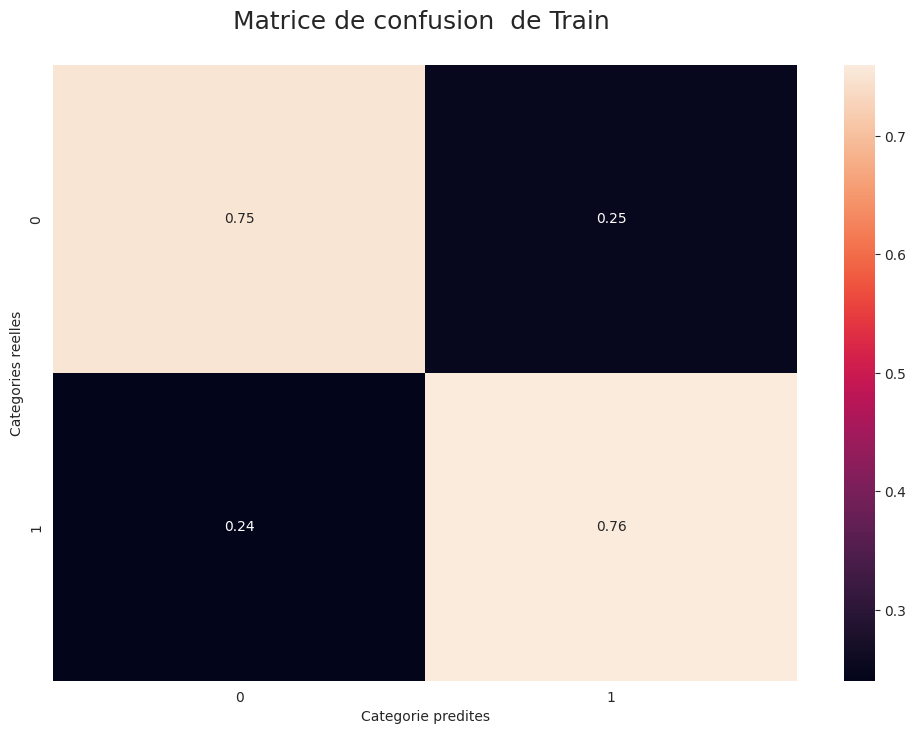

F2 score model 1 :  0.42137310271796674


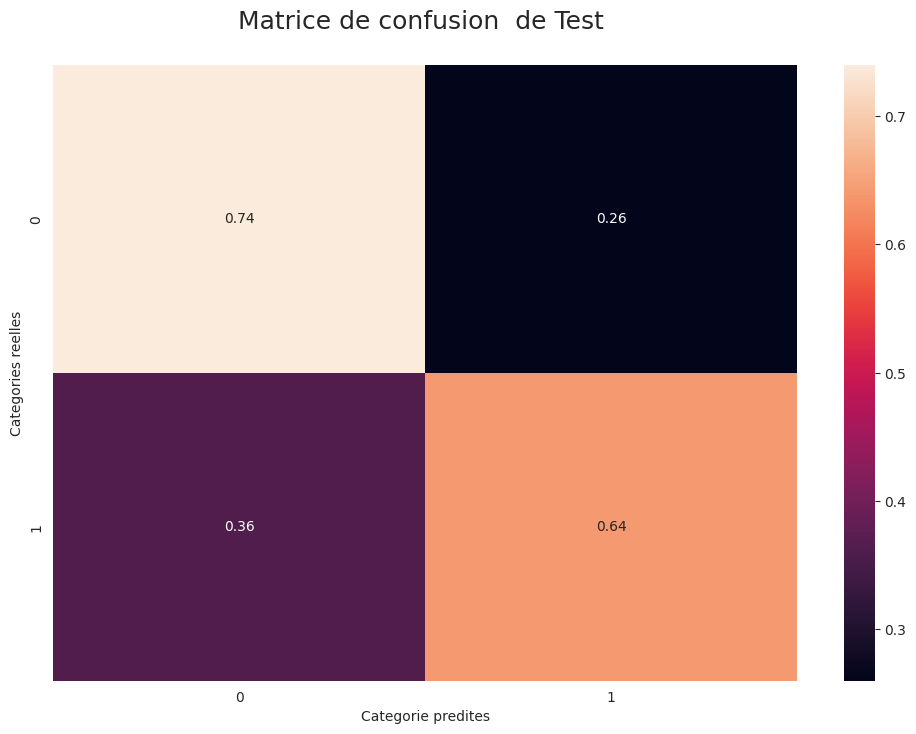

In [27]:
be = model.best_estimator_

with mlflow.start_run():
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", "") # str(be['under'])
    mlflow.log_param("Top X features", train_df.shape[1])
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [28]:
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier(min_samples_split =  100, max_features='sqrt', max_depth=15, class_weight='balanced') #


# Parametres Random Forest
params = {
    'estimator__n_estimators' : [200, 300, 500]
}

pipeline = Pipeline(
    [
        ("imputer", s_imputer),
        ("scaler", mm_scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=15,
                                                               min_samples_split=100))]),
             param_grid={'estimator__n_estimators': [200, 300, 500]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [29]:
model.best_params_

{'estimator__n_estimators': 300}

In [30]:
df_results_grid = grid_resultification(model)
df_results_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,19.151524,0.925923,0.934977,0.01859,200,{'estimator__n_estimators': 200},0.419816,0.004979,2,0.499068,0.001557
1,27.289496,0.186334,1.359472,0.00389,300,{'estimator__n_estimators': 300},0.420350,0.005497,1,0.498918,0.001973
2,45.302901,1.080594,2.280188,0.07782,500,{'estimator__n_estimators': 500},0.419594,0.004291,3,0.499429,0.001741


 TRAIN F2 score model :  0.4968927724002862


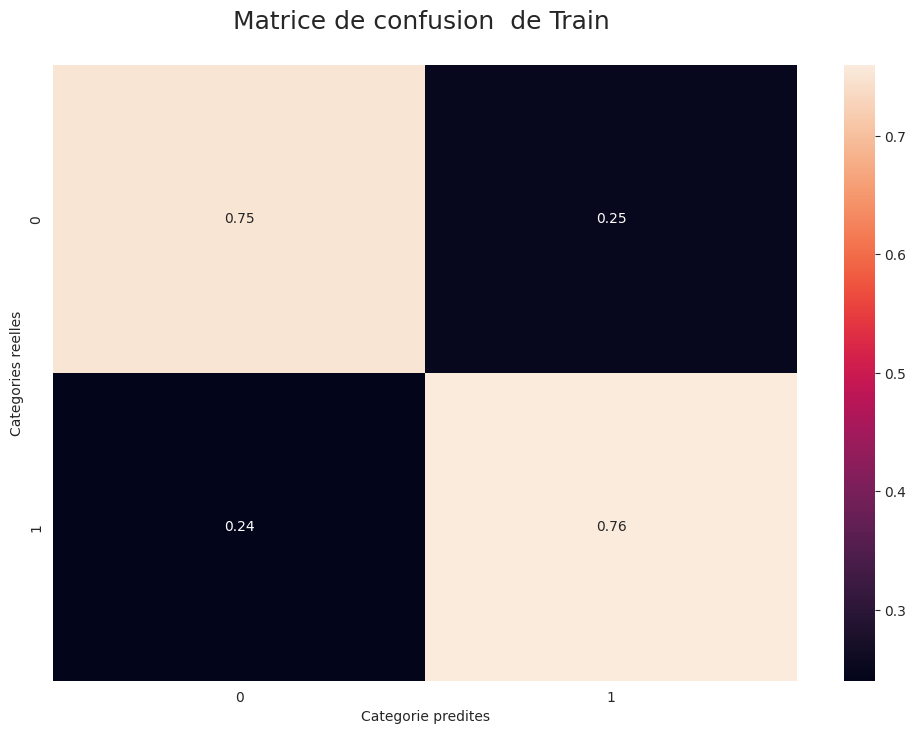

F2 score model 1 :  0.4212231672742001


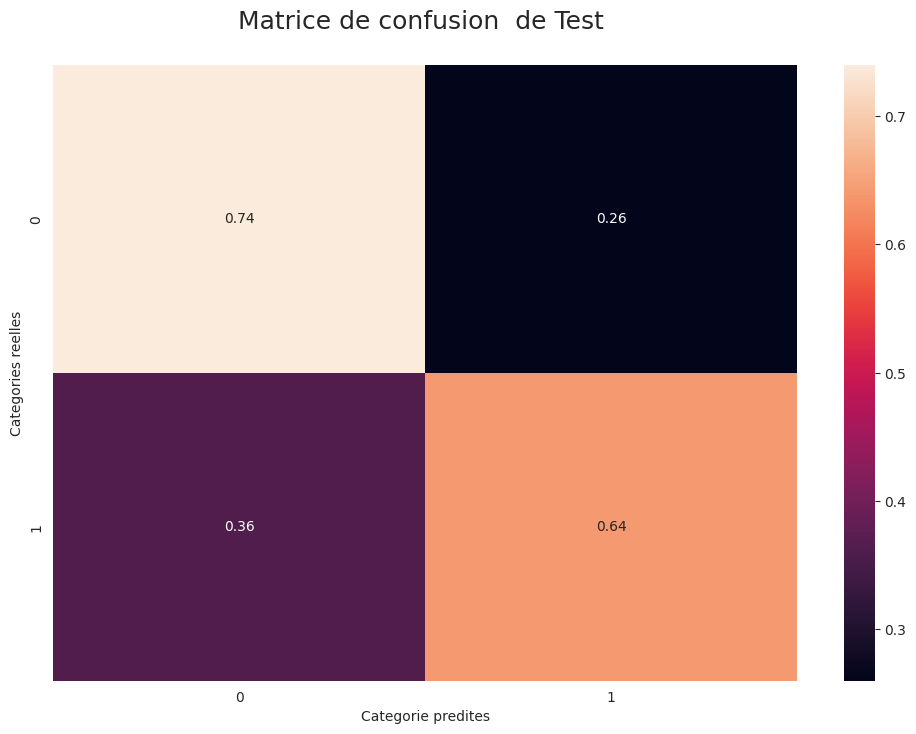

In [31]:
be = model.best_estimator_
be.fit(X_train, y_train)

with mlflow.start_run():
    mlflow.log_param("imputer", str(be['imputer']))
    mlflow.log_param("scaler", str(be['scaler']))
    mlflow.log_param("estimator", str(be['estimator']))
    mlflow.log_param("over-sampler", str(be['over']))
    mlflow.log_param("under-sampler", "") # str(be['under'])
    mlflow.log_param("Top X features", train_df.shape[1])
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

- Enelever le stratify KFold mais GirdSearcher sur l'over-sampling Rate

In [40]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = mm_scaler
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier(min_samples_split =  100, max_features='sqrt', max_depth=15, class_weight='balanced', n_estimators=200)

In [41]:
model = Pipeline(
    [
        ("imputer", SimpleImputer(missing_values=np.nan, strategy='median')),
        ("scaler", StandardScaler()),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=100,
                                        n_estimators=200))])

 TRAIN F2 score model :  0.49818895034267163


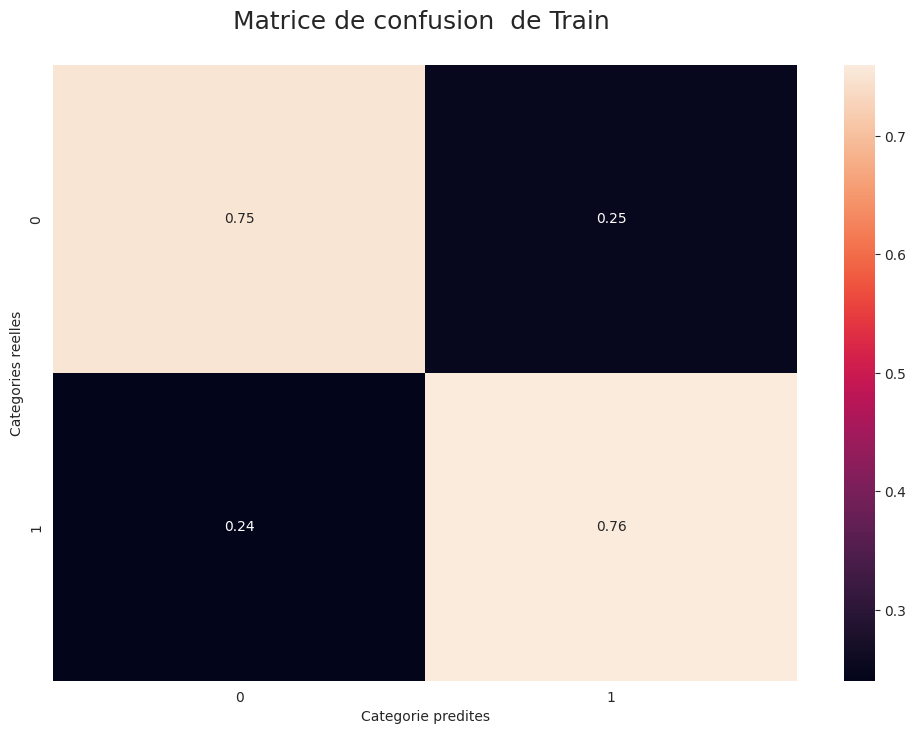

F2 score model 1 :  0.4204201562390035


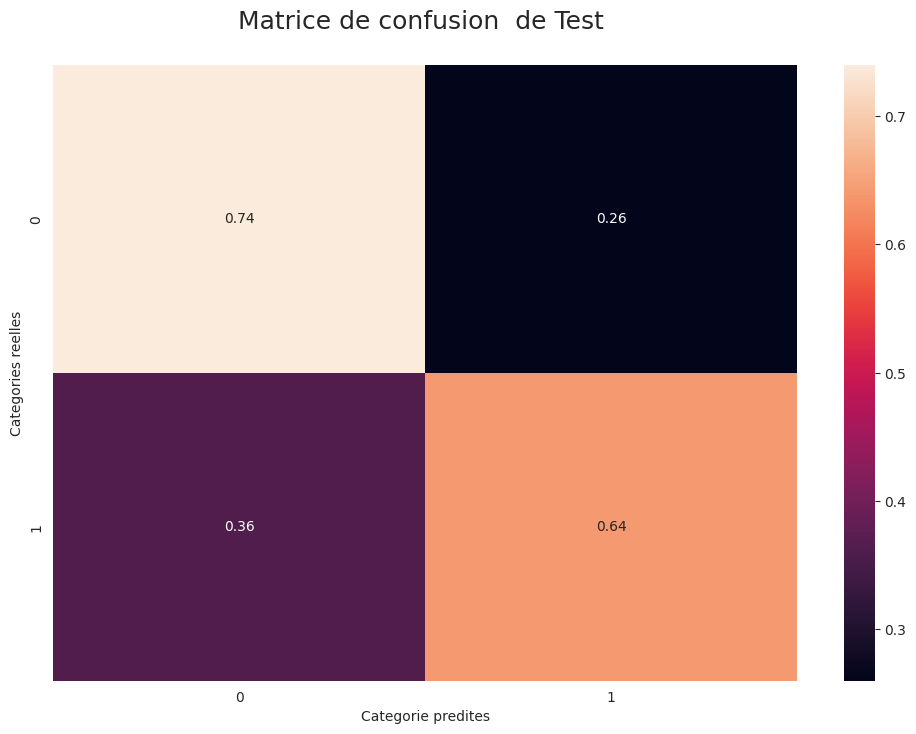

In [42]:
with mlflow.start_run():
    mlflow.log_param("imputer", "Median Simple Imputer")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("estimator", estimator)
    mlflow.log_param("over-sampler", over)
    mlflow.log_param("under-sampler", under)
    mlflow.log_param("Top X features", train_df.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [43]:
model = Pipeline(
    [
        ("imputer", SimpleImputer(missing_values=np.nan, strategy='median')),
        ("scaler", StandardScaler()),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        # ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=100,
                                        n_estimators=200))])

 TRAIN F2 score model :  0.5989671445107292


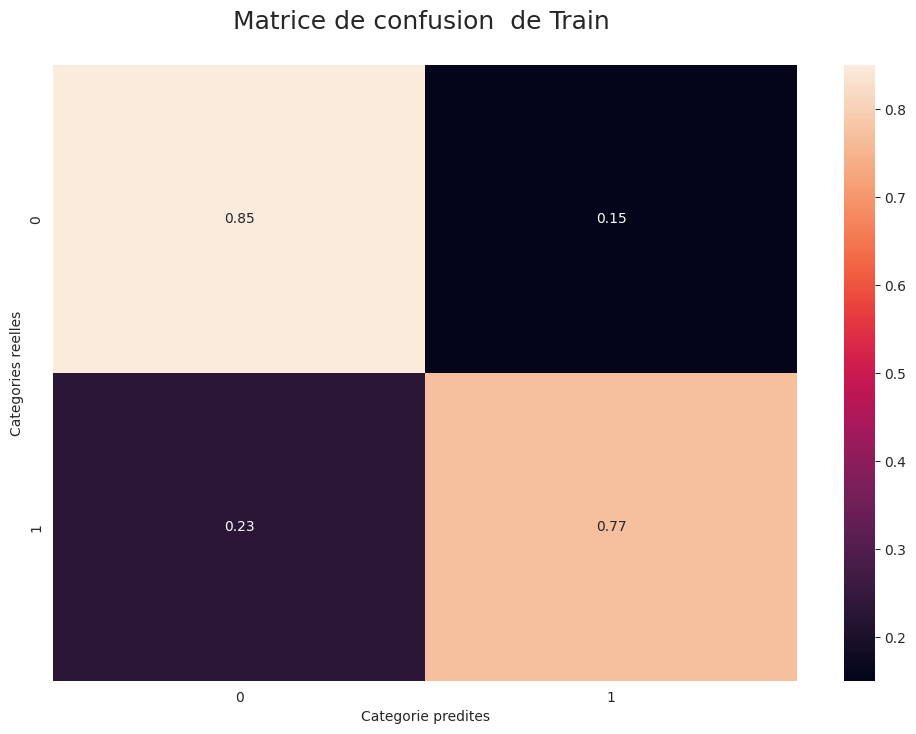

F2 score model 1 :  0.39237927195580474


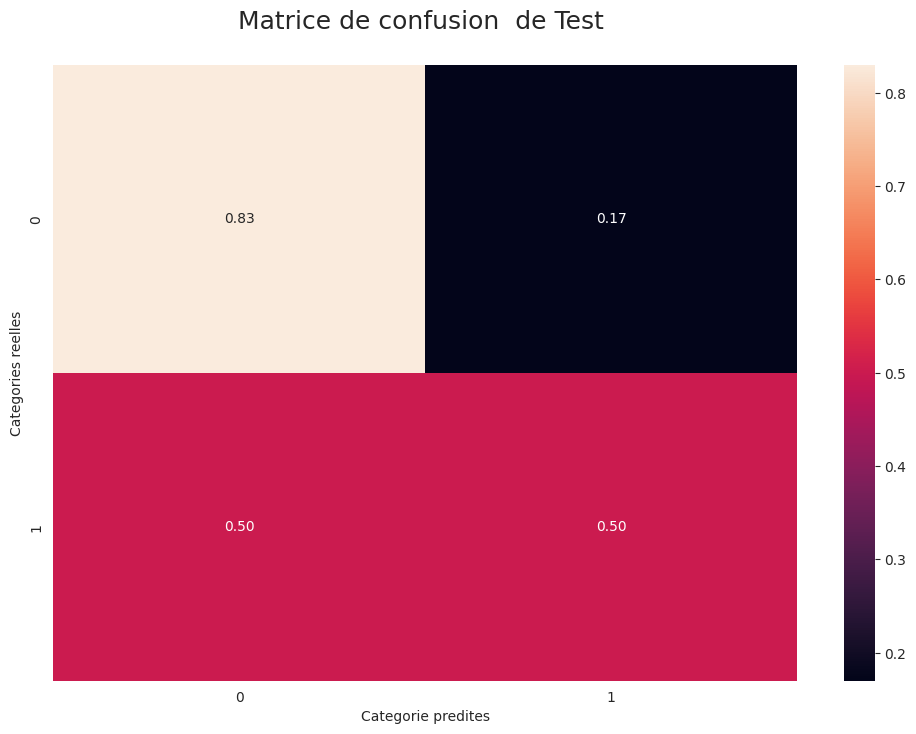

In [44]:
with mlflow.start_run():
    mlflow.log_param("imputer", "Median Simple Imputer")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("estimator", estimator)
    mlflow.log_param("over-sampler", over)
    mlflow.log_param("under-sampler", "None")
    mlflow.log_param("Top X features", train_df.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [45]:
estimator = RandomForestClassifier()

model = Pipeline(
    [
        ("imputer", SimpleImputer(missing_values=np.nan, strategy='mean')),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', RandomForestClassifier())])

 TRAIN F2 score model :  0.8469314149803097


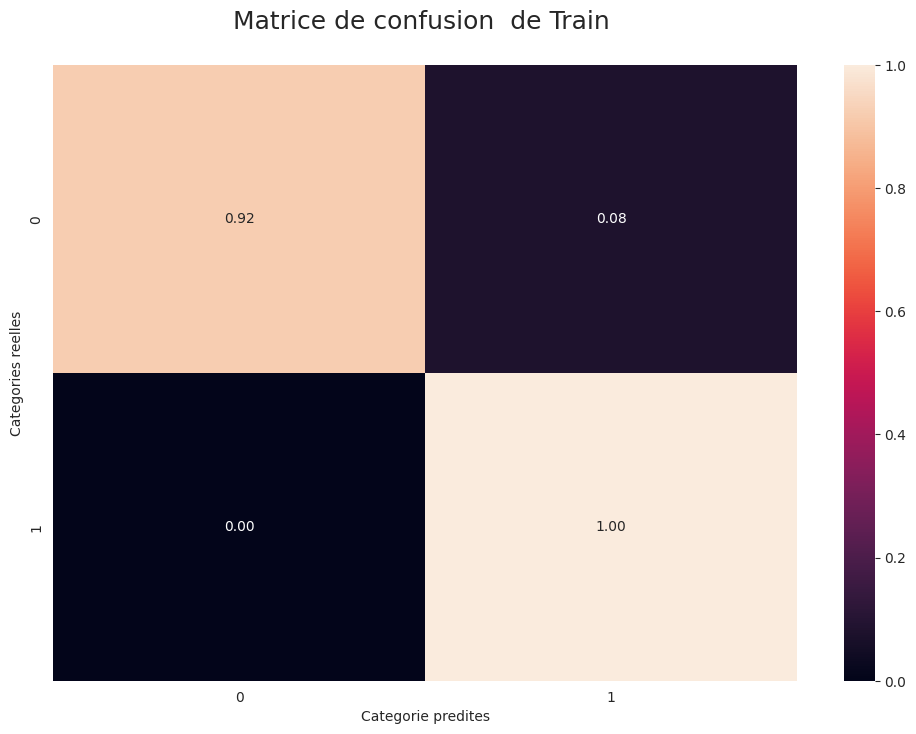

F2 score model 1 :  0.3378345260268601


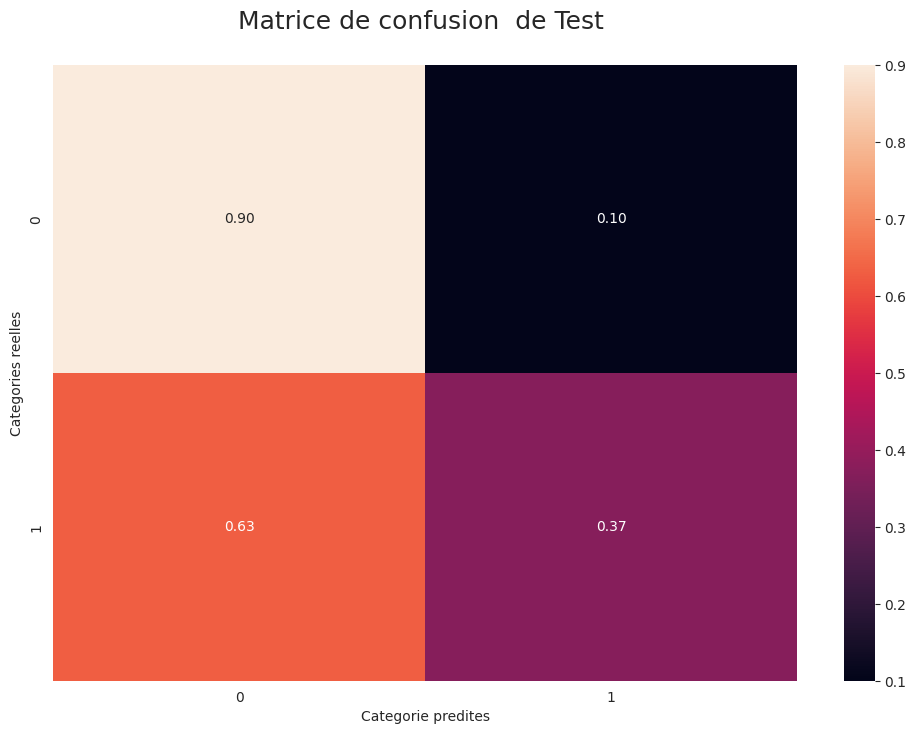

In [47]:
with mlflow.start_run():
    mlflow.log_param("imputer", "Median Simple Imputer")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("estimator", estimator)
    mlflow.log_param("over-sampler", over)
    mlflow.log_param("under-sampler", "None")
    mlflow.log_param("Top X features", train_df.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [48]:
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(random_state=RANDOM_STATE)
estimator = RandomForestClassifier(min_samples_split =  100, max_features='sqrt', max_depth=20, class_weight='balanced', n_estimators=200) #


# Parametres Random Forest
params = {
    'under__sampling_strategy' : [0.2, 0.3, 0.5]
}

pipeline = Pipeline(
    [
        ("imputer", s_imputer),
        ("scaler", mm_scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=20,
                                                               min_samples_split=100,
                                                               n_estimators=200))]),
             param_grid={'under__sampling_strategy': [0.2, 0.3, 0.5]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [50]:
model.best_params_
model = model.best_estimator_
model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_split=100,
                                        n_estimators=200))])

 TRAIN F2 score model :  0.508122028526149


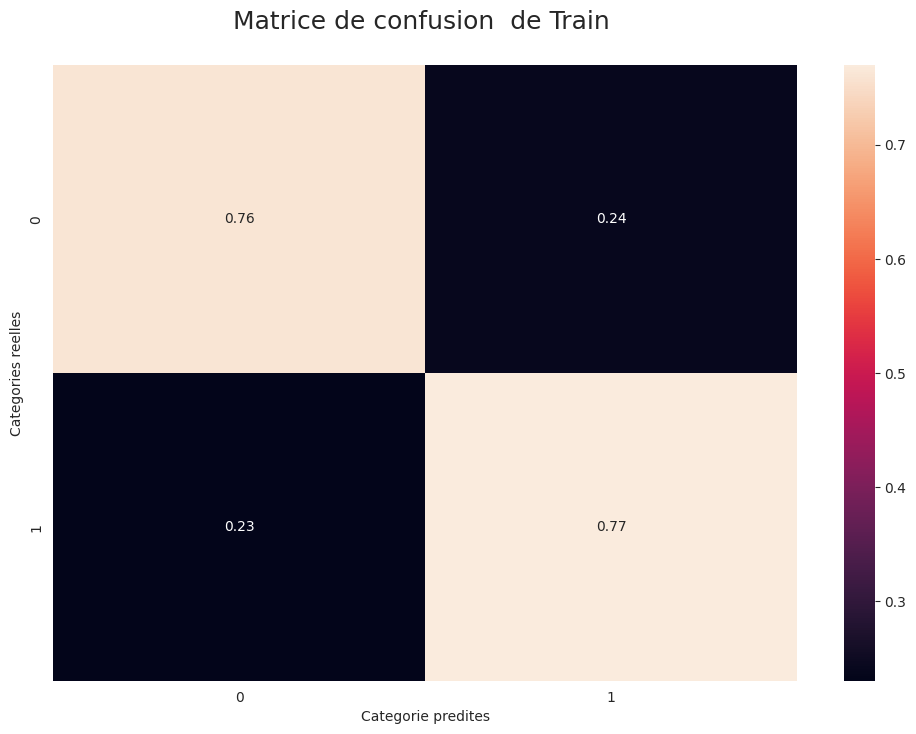

F2 score model 1 :  0.4214979072045596


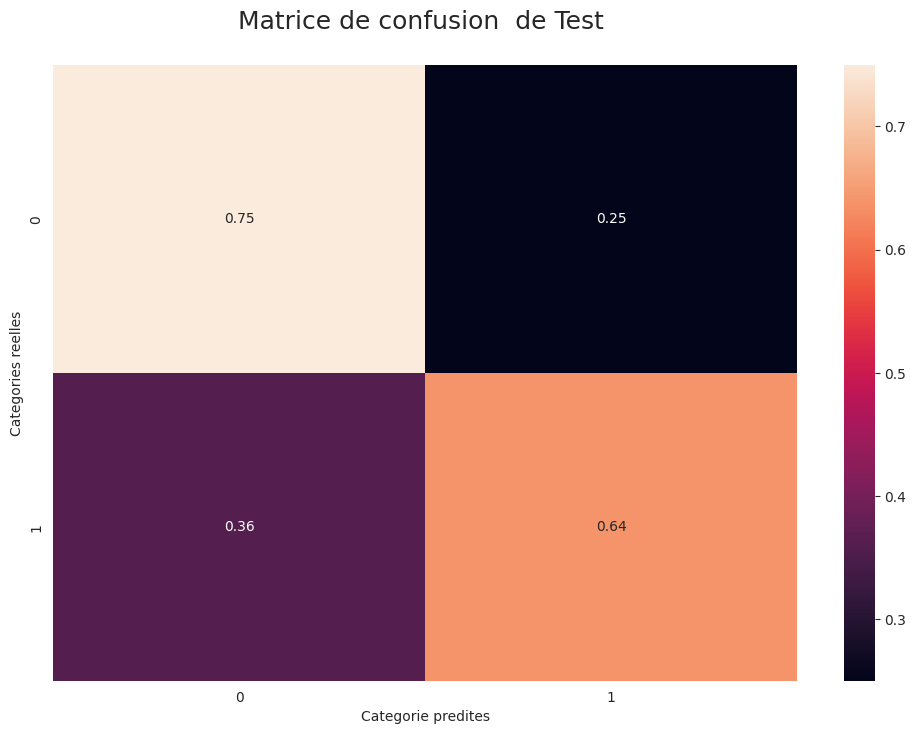

In [51]:
with mlflow.start_run():
    mlflow.log_param("imputer", str(s_imputer))
    mlflow.log_param("scaler", str(mm_scaler))
    mlflow.log_param("estimator", estimator)
    mlflow.log_param("over-sampler", over)
    mlflow.log_param("under-sampler", under)
    mlflow.log_param("Top X features", train_df.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

# DELIRIUM TREMENS

In [6]:
s_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
mm_scaler = MinMaxScaler(feature_range=(0, 1))
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier(min_samples_split =  100, max_features='sqrt', max_depth=15, class_weight='balanced', n_estimators=200)
imputer = s_imputer
scaler = mm_scaler
oversampler = over
undersampler = under

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=100,
                                        n_estimators=200))])

/home/maximorose/anaconda3/envs/oc_ds_p7/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


 TRAIN F2 score model :  0.5536692398859668


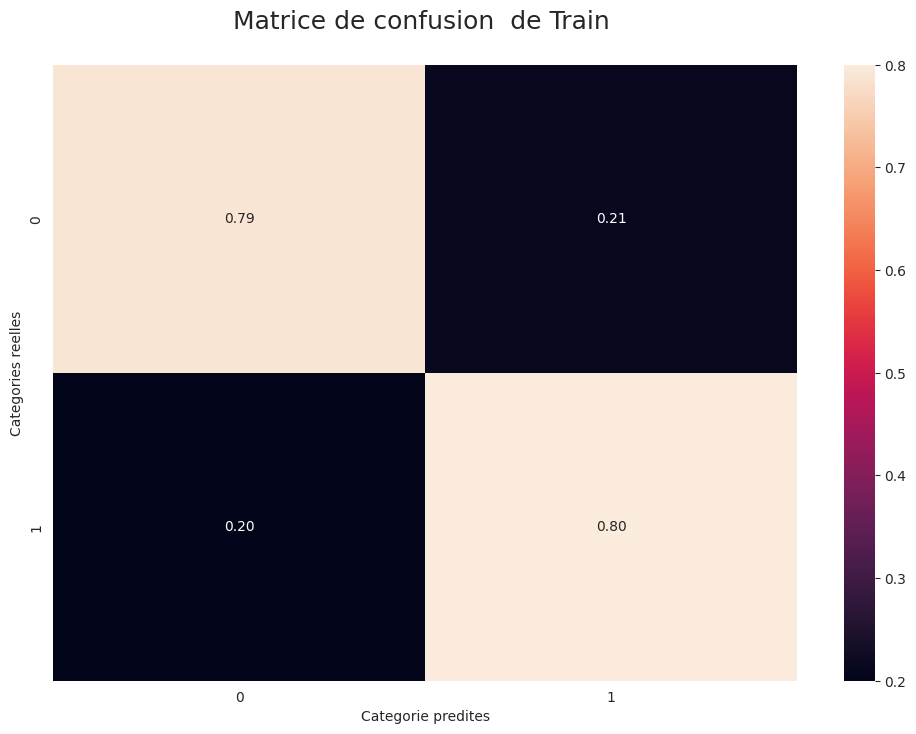

F2 score model 1 :  0.4153339604891816


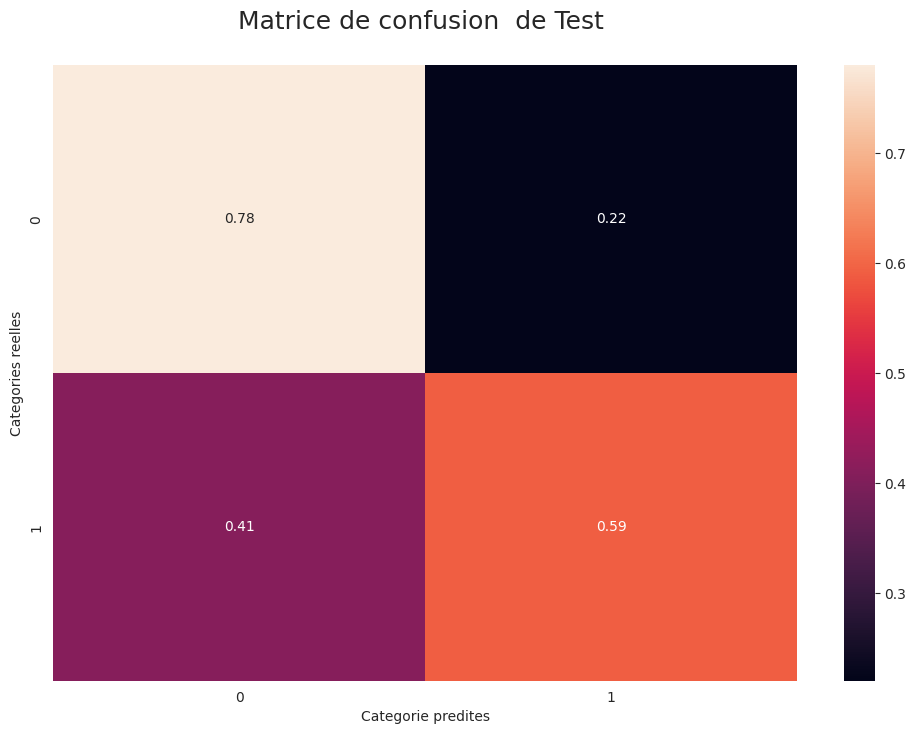

In [7]:
import mlflow.sklearn
from mlflow.models.signature import infer_signature

df_xtrain = pd.DataFrame(X_train, columns=X.columns)

with mlflow.start_run():
    signature = infer_signature(df_xtrain, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [8]:
# y_pred = model.predict(X_test)
# y_train_pred = model.predict(X_train)
#
# # -------------------------- LOG RESULTS ------------------
# # Generation des resultats :
# # TRAIN RESULTS
# fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
# train_auc_score = auc(fpr, tpr)
# train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
# train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
# print(" TRAIN F2 score model : ", train_F2_score)
# print(" TRAIN AUC : ", train_auc_score)
# print(" TRAIN Rappel : ", train_rappel)
# print("------")
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# train_auc_score = auc(fpr, tpr)
# train_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
# train_rappel = recall_score(y_true=y_test, y_pred=y_pred)
# print(" TEST F2 score model : ", train_F2_score)
# print(" TEST AUC : ", train_auc_score)
# print(" TEST Rappel : ", train_rappel)

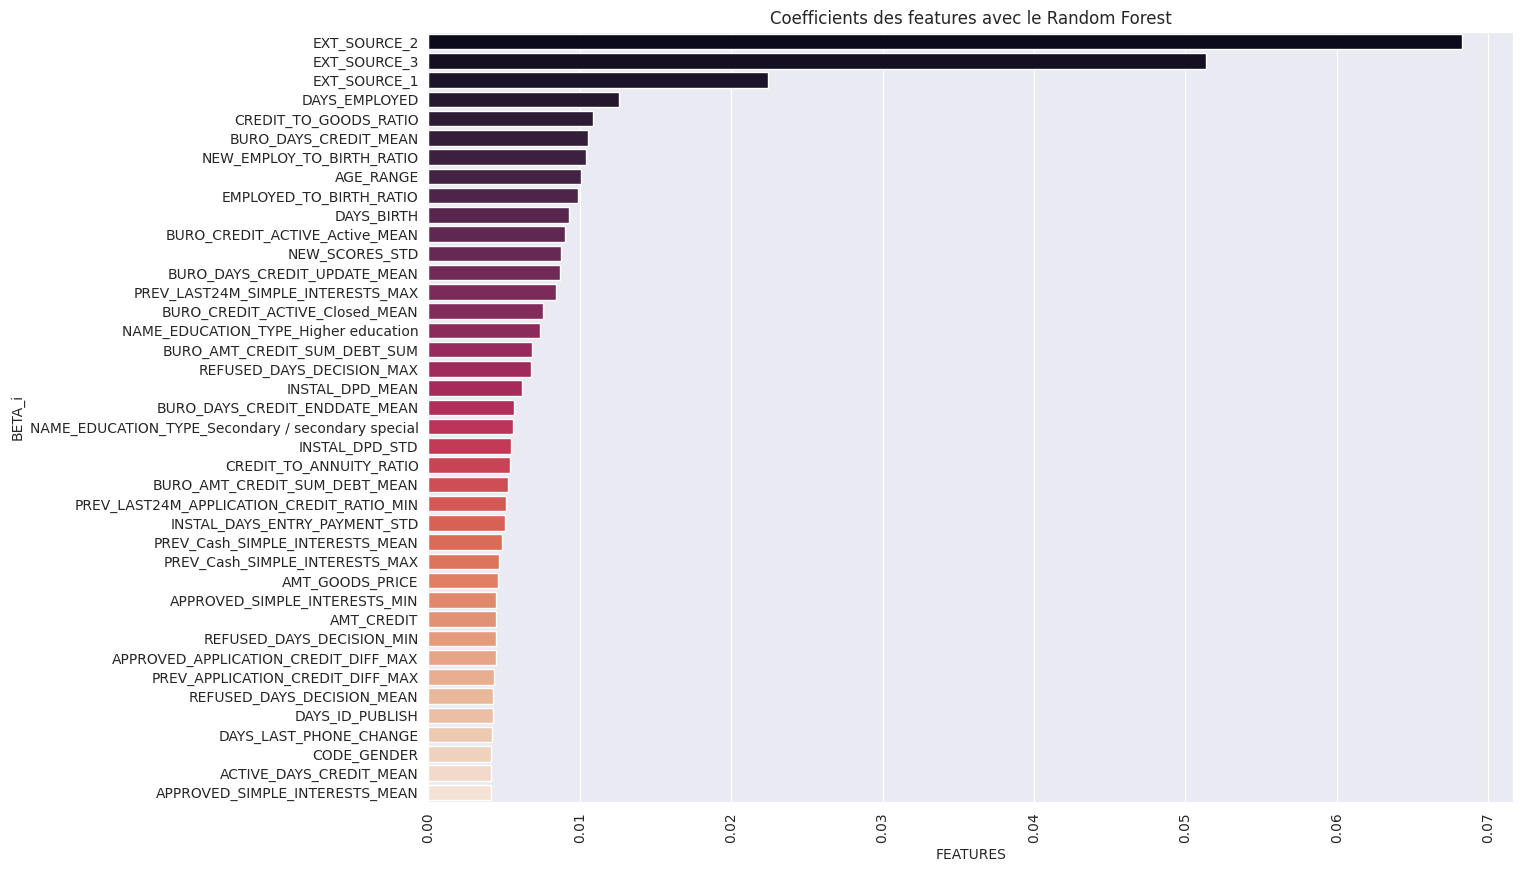

In [11]:
featimps = feature_importance_rf(xtrain=X_train, modelrf=model['estimator'], size=40)

In [12]:
light_train_df = train_df[featimps['feature'].values.tolist()]
X_train, X_test, y_train, y_test = train_test_split(light_train_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")
model.fit(X_train, y_train)

X_train : (215254, 40) // X_test : (92252, 40)
y_train : (215254,) // y_test : (92252,)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=100,
                                        n_estimators=200))])

 TRAIN F2 score model :  0.500461359270296


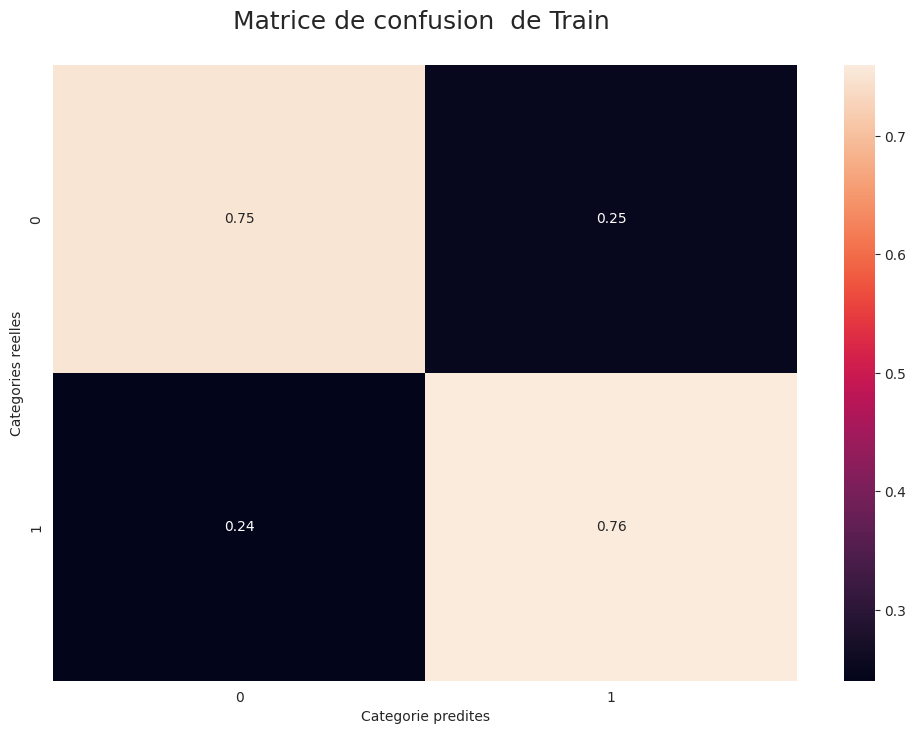

F2 score model 1 :  0.4212538496937945


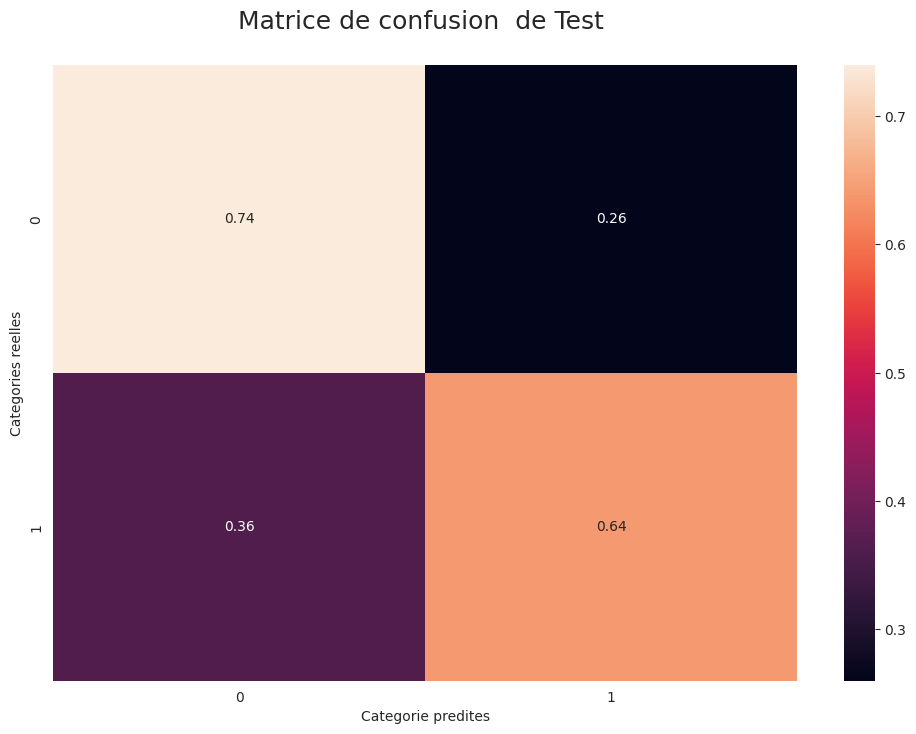

In [14]:
df_xtrain = pd.DataFrame(X_train, columns=X.columns)

with mlflow.start_run():
    signature = infer_signature(df_xtrain, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

# TEST FE OC

In [15]:
fe_filename = 'OCkernel_customized.csv'
df = pd.read_csv(INPUT_FOLDER+fe_filename)
df = ckk.reduce_memory(df)
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

X = train_df.drop(columns = ['TARGET'])
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Initial df memory usage is 1720.48 MB for 633 columns
Final memory usage is: 531.70 MB - decreased by 69.1%
Train shape: (307507, 633), test shape: (48744, 633)
X_train : (215254, 632) // X_test : (92253, 632)
y_train : (215254,) // y_test : (92253,)


In [16]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier(min_samples_split =  100, max_features='sqrt', max_depth=15, class_weight='balanced', n_estimators=200)

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=100,
                                        n_estimators=200))])

/home/maximorose/.local/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 TRAIN F2 score model :  0.53613769742802


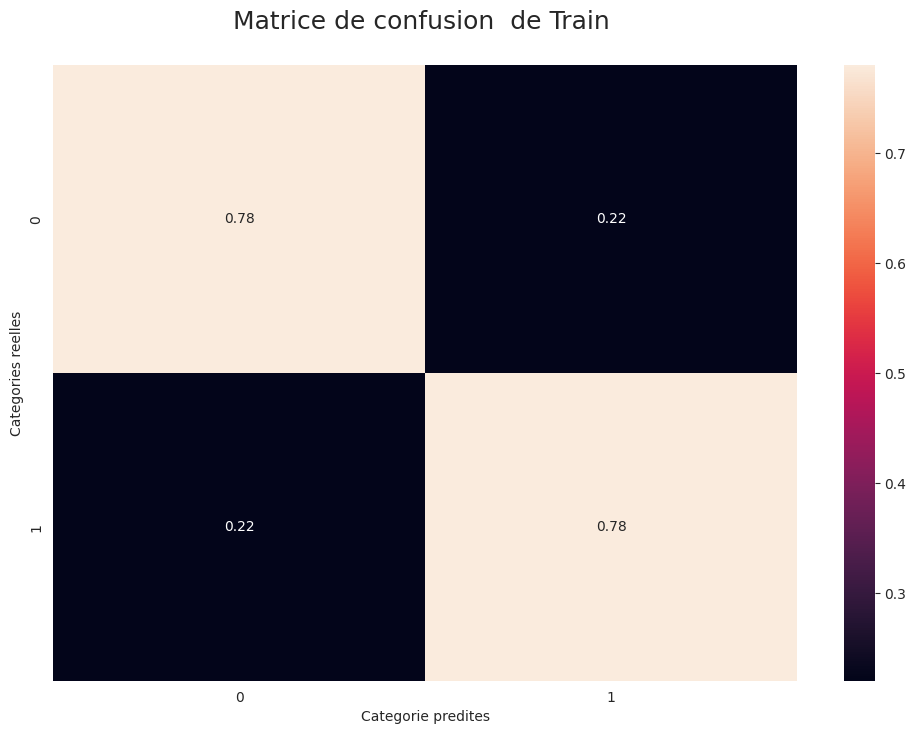

F2 score model 1 :  0.41229108120100577


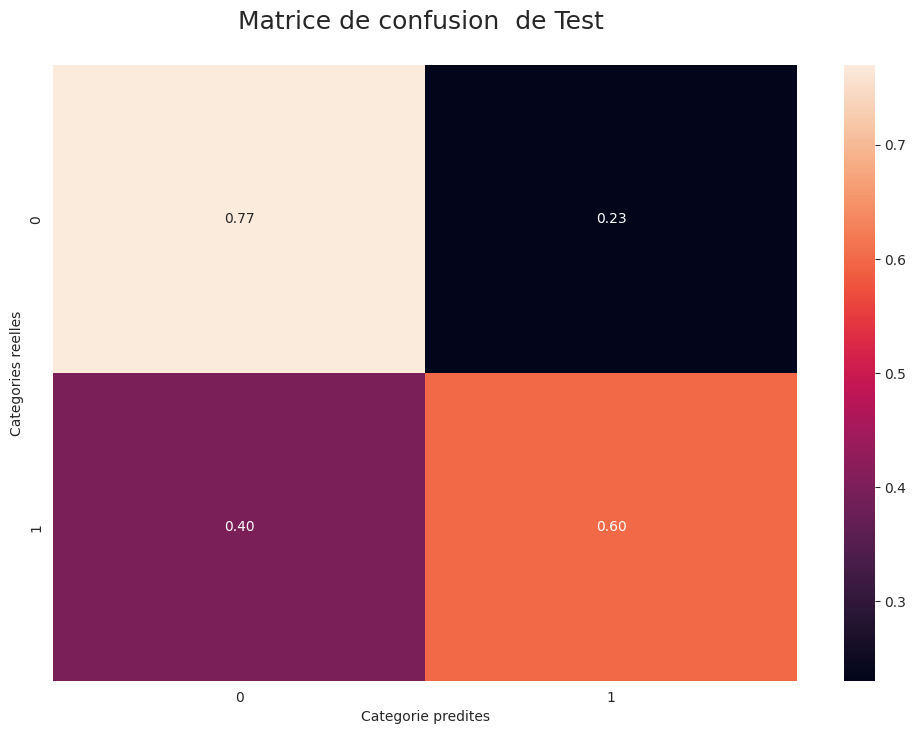

In [18]:
df_xtrain = pd.DataFrame(X_train, columns=X.columns)

with mlflow.start_run():
    signature = infer_signature(df_xtrain, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    mlflow.log_param("Feature Engineering", str(fe_filename))
    mlflow.log_param("NB TOP FEATURES", X_train.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

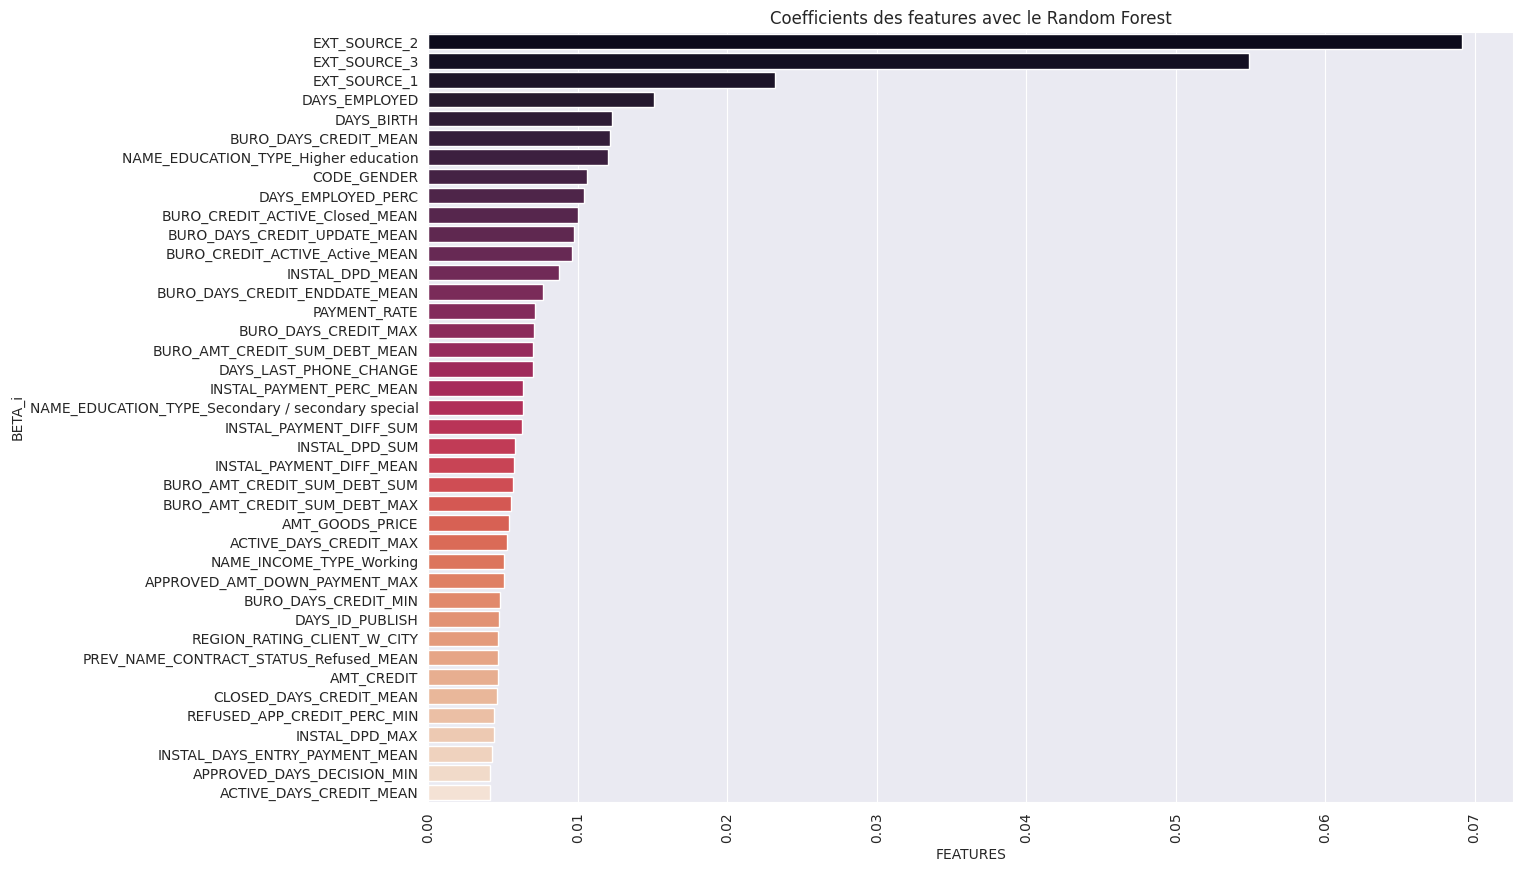

In [19]:
NB_TOP_FEATURES = 40
featimps = feature_importance_rf(xtrain=X_train, modelrf=model['estimator'], size=NB_TOP_FEATURES)

In [20]:
light_train_df = train_df[featimps['feature'].values.tolist()]
X_train, X_test, y_train, y_test = train_test_split(light_train_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")
model.fit(X_train, y_train)

X_train : (215254, 40) // X_test : (92253, 40)
y_train : (215254,) // y_test : (92253,)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=100,
                                        n_estimators=200))])

/home/maximorose/.local/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 TRAIN F2 score model :  0.4939565168581372


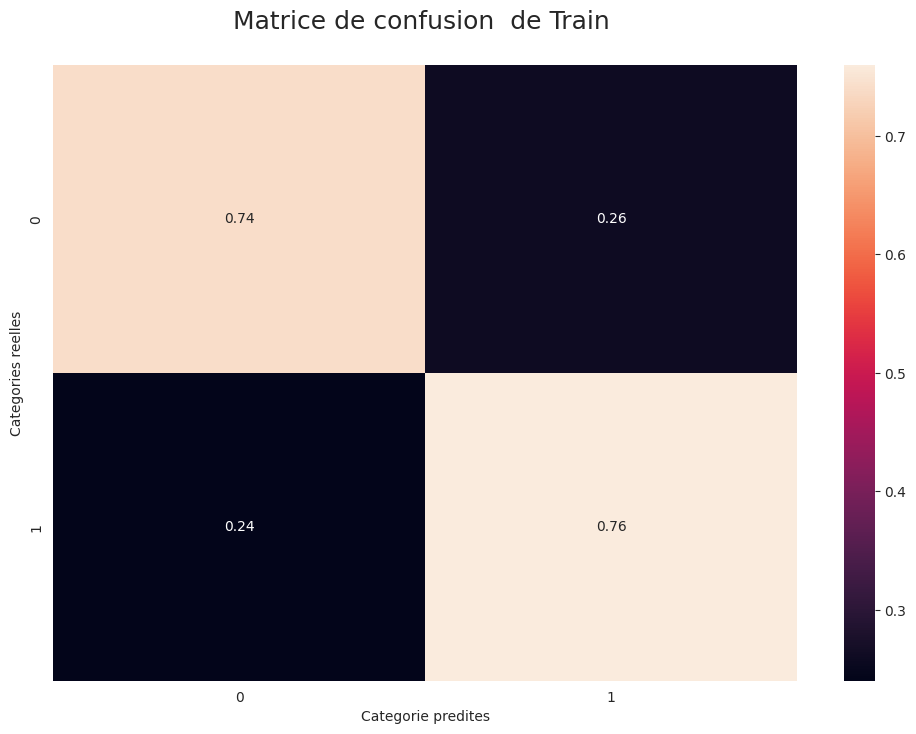

F2 score model 1 :  0.4194651468654099


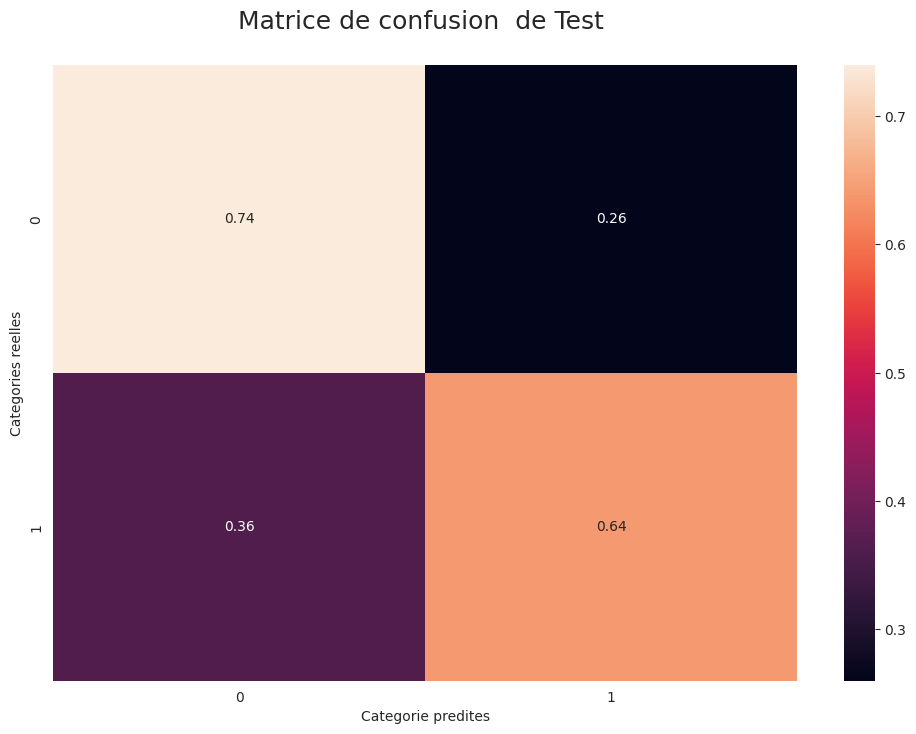

In [21]:
df_xtrain = pd.DataFrame(X_train, columns=X.columns)

with mlflow.start_run():
    signature = infer_signature(df_xtrain, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    mlflow.log_param("Feature Engineering", str(fe_filename))
    mlflow.log_param("NB TOP FEATURES", X_train.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [23]:
light_train_df = light_train_df.drop(columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])
X_train, X_test, y_train, y_test = train_test_split(light_train_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")
model.fit(X_train, y_train)

X_train : (215254, 37) // X_test : (92253, 37)
y_train : (215254,) // y_test : (92253,)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=100,
                                        n_estimators=200))])

/home/maximorose/.local/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 TRAIN F2 score model :  0.4706694476815392


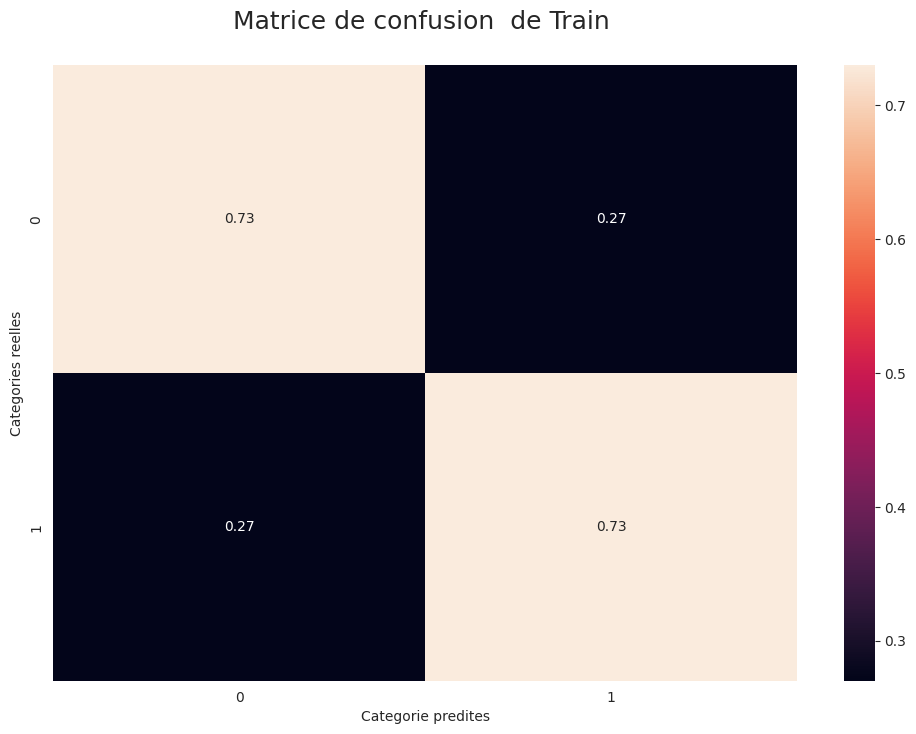

F2 score model 1 :  0.37781028507740794


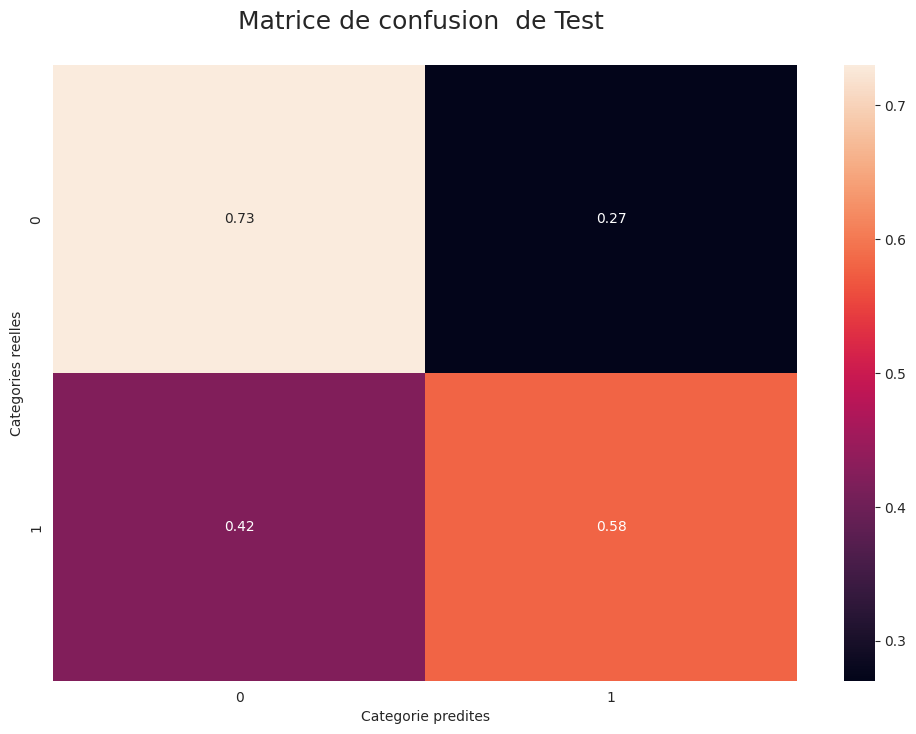

In [24]:
df_xtrain = pd.DataFrame(X_train, columns=X.columns)

with mlflow.start_run():
    signature = infer_signature(df_xtrain, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    mlflow.log_param("Feature Engineering", str(fe_filename))
    mlflow.log_param("NB TOP FEATURES", X_train.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [29]:
X_noExt = train_df.drop(columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET'])
X_train, X_test, y_train, y_test = train_test_split(X_noExt, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

X_train : (215254, 629) // X_test : (92253, 629)
y_train : (215254,) // y_test : (92253,)


In [30]:
estimator = RandomForestClassifier(min_samples_split =  100, max_features='sqrt', class_weight='balanced', n_estimators=200) #


# Parametres Random Forest
params = {
    'estimator__max_depth' : [10, 20, 50, 100]
}

pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               min_samples_split=100,
                                                               n_estimators=200))]),
             param_grid={'estimator__max_depth': [10, 20, 50, 100]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [31]:
print("Best params : ", model.best_params_)
print("Best score : ", model.best_score_)

Best params :  {'estimator__max_depth': 10}
Best score :  0.384830060430977


In [32]:
def grid_resultification(grid) :
    res = pd.DataFrame(grid.cv_results_)
    keepcols = [col for col in res.columns if "split" not in col]
    res = res[keepcols]
    # res = res.sort_values(by = ['rank_test_r2', 'rank_test_neg_mean_absolute_error'])
    return res

df_results_grid = grid_resultification(model)
df_results_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,56.473597,6.477870,1.561789,0.023410,10,{'estimator__max_depth': 10},0.384830,0.003811,1,0.457468,0.001794
1,64.797515,0.438122,2.096400,0.017782,20,{'estimator__max_depth': 20},0.380787,0.004655,2,0.558488,0.002460
2,67.276939,0.653378,2.191788,0.030533,50,{'estimator__max_depth': 50},0.377942,0.005166,4,0.577320,0.002158
3,67.884064,0.337397,2.198397,0.012307,100,{'estimator__max_depth': 100},0.378310,0.004023,3,0.578080,0.002519


In [33]:
be = model.best_estimator_
be.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=100,
                                        n_estimators=200))])

In [36]:
mlflow.end_run()

/home/maximorose/.local/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 TRAIN F2 score model :  0.45005323249752194


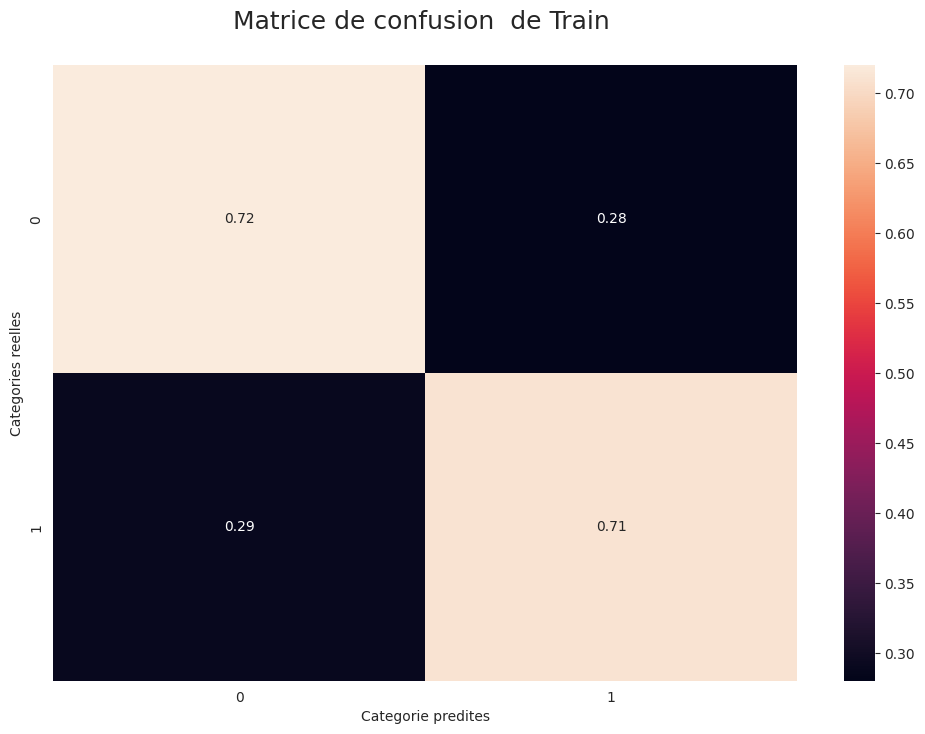

F2 score model 1 :  0.39003371404981424


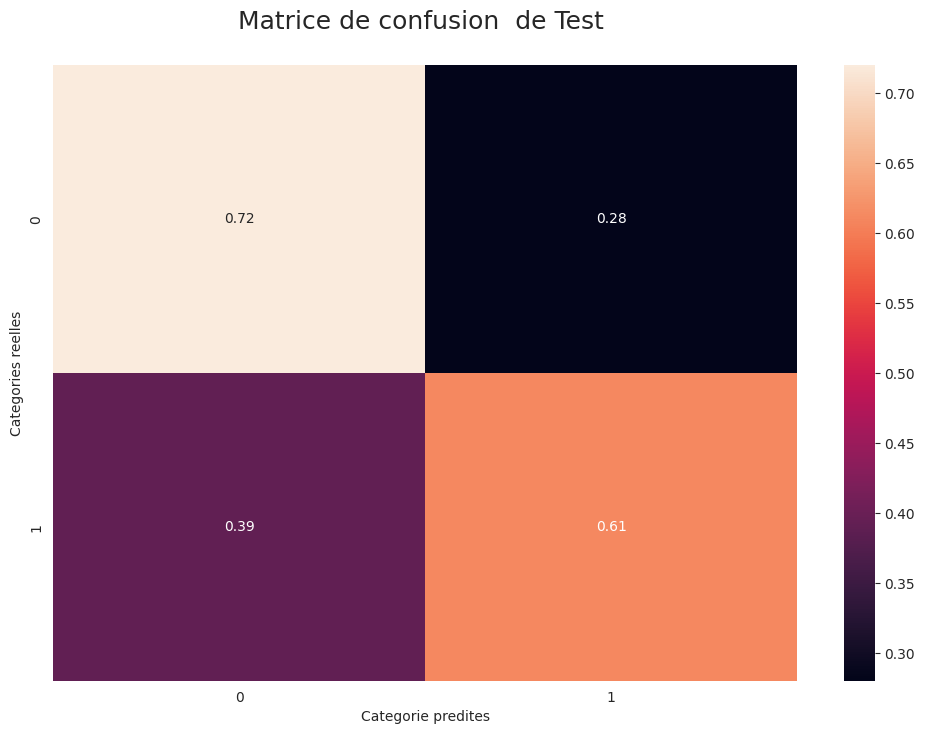

In [37]:
model = be

with mlflow.start_run():
    signature = infer_signature(df_xtrain, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    mlflow.log_param("Feature Engineering", str(fe_filename))
    mlflow.log_param("NB TOP FEATURES", X_train.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [38]:
estimator = RandomForestClassifier()

pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', RandomForestClassifier())])

/home/maximorose/.local/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 TRAIN F2 score model :  0.9048868891388577


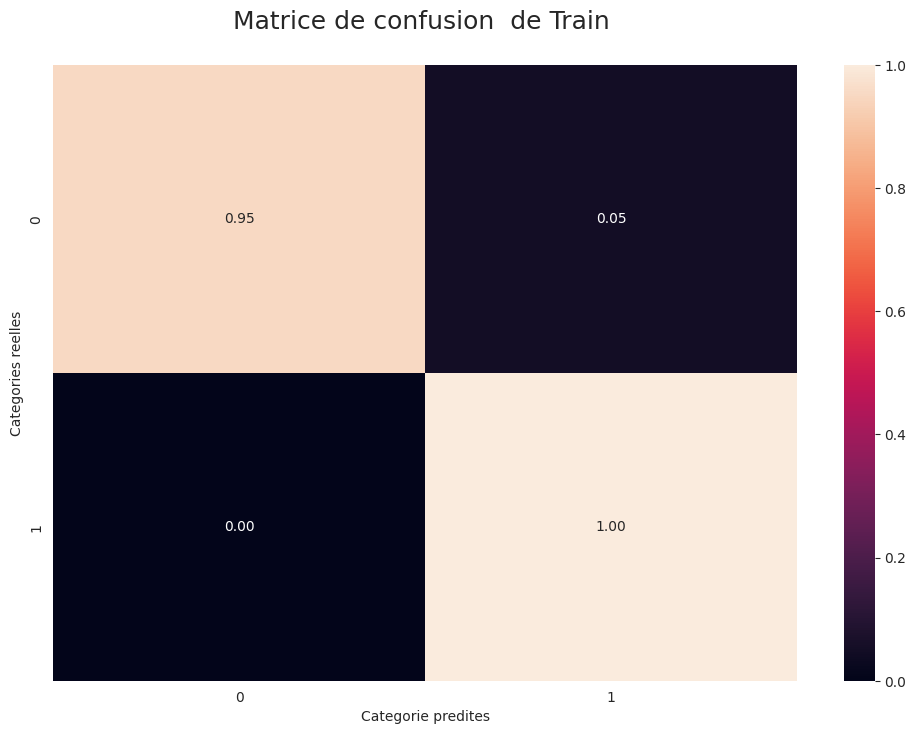

F2 score model 1 :  0.23530862843986405


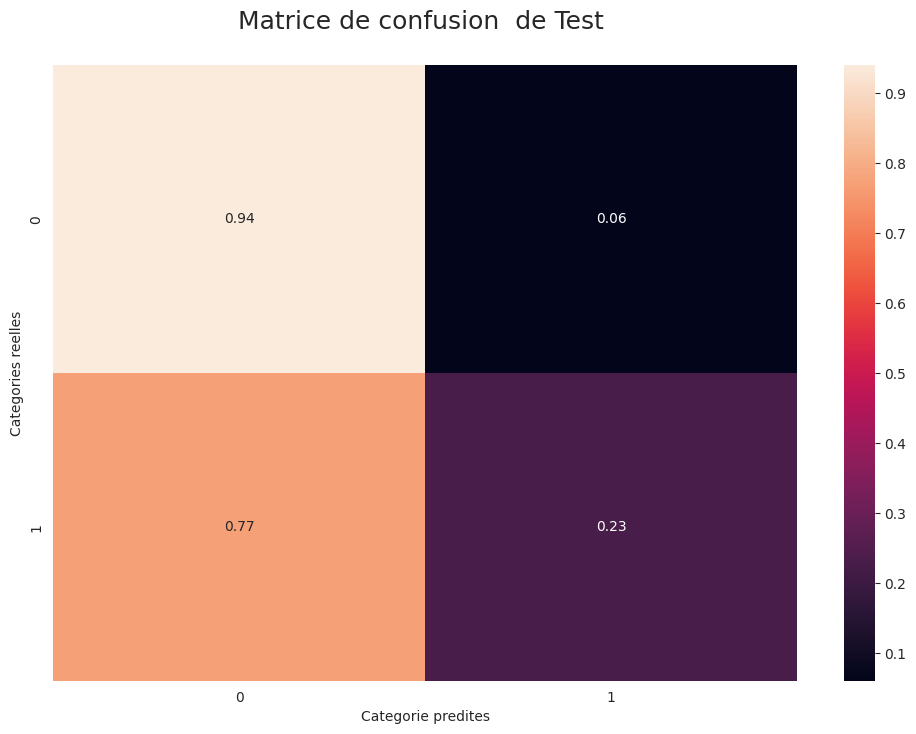

In [39]:
model = pipeline

with mlflow.start_run():
    signature = infer_signature(df_xtrain, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    mlflow.log_param("Feature Engineering", str(fe_filename))
    mlflow.log_param("NB TOP FEATURES", X_train.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

In [45]:
estimator = RandomForestClassifier(max_features='sqrt', class_weight='balanced', n_estimators=200) #


# Parametres Random Forest
params = {
    'estimator__max_depth' : [20, None],
    'estimator__min_samples_split' : [200, 500]
}

pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=200))]),
             param_grid={'estimator__max_depth': [20, None],
                         'estimator__min_samples_split': [200, 500]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [46]:
print("Best params : ", model.best_params_)
print("Best score : ", model.best_score_)

Best params :  {'estimator__max_depth': 20, 'estimator__min_samples_split': 200}
Best score :  0.38757300266236144


In [47]:
df_results_grid = grid_resultification(model)
df_results_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,64.339196,4.735130,1.899922,0.051085,20,"{'estimator__max_depth': 20, 'estimator__min_s...",0.387573,0.002613,1,0.486117,0.002384
1,52.333410,0.535738,1.429890,0.008727,20,"{'estimator__max_depth': 20, 'estimator__min_s...",0.386314,0.002193,3,0.427910,0.002237
2,62.398640,0.211573,1.943175,0.008236,None,"{'estimator__max_depth': None, 'estimator__min...",0.387205,0.002515,2,0.490622,0.002045
3,52.704111,0.440293,1.444594,0.005021,None,"{'estimator__max_depth': None, 'estimator__min...",0.384805,0.003425,4,0.428303,0.001796


In [48]:
be = model.best_estimator_
model = be
model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_split=200,
                                        n_estimators=200))])

/home/maximorose/.local/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


 TRAIN F2 score model :  0.48375128138435414


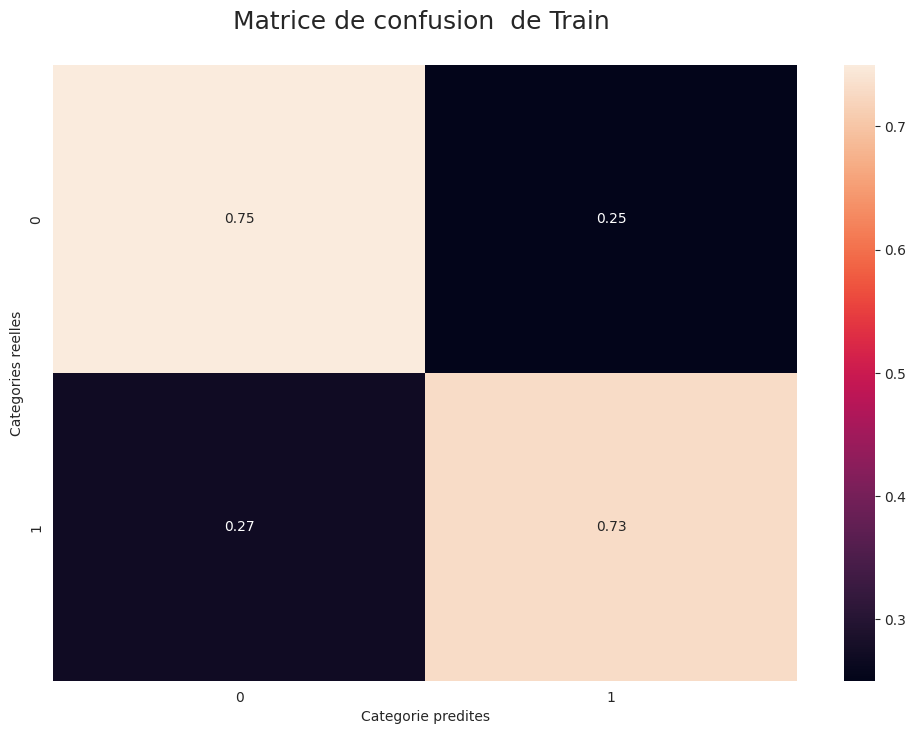

F2 score model 1 :  0.3894181602884978


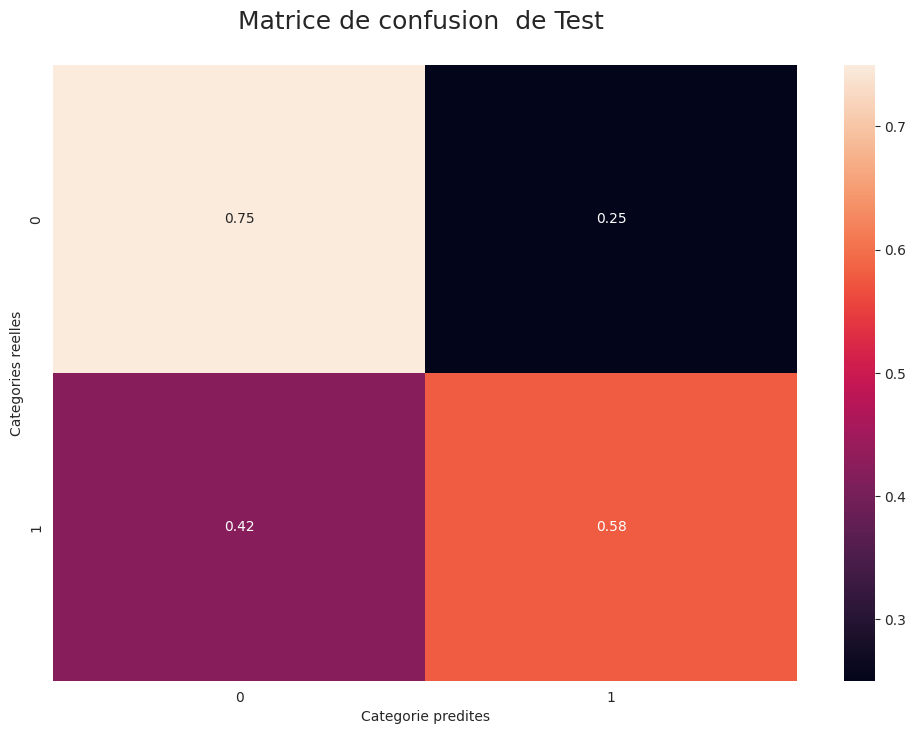

In [49]:
with mlflow.start_run():
    signature = infer_signature(df_xtrain, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    mlflow.log_param("Feature Engineering", str(fe_filename))
    mlflow.log_param("NB TOP FEATURES", X_train.shape[1])
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

# SPLIT TRAIN AND TEST FOR PREPROCESSING

In [2]:
fe_filename = 'kernel03_install_payments_Train_Only.csv'
df = pd.read_csv(INPUT_FOLDER+fe_filename)
df = ckk.reduce_memory(df)

X = df.drop(columns = ['TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier(max_features='sqrt', class_weight='balanced', n_estimators=200, max_depth=20, min_samples_split=200)

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

Initial df memory usage is 1252.81 MB for 534 columns
Final memory usage is: 409.39 MB - decreased by 67.3%
X_train : (215254, 533) // X_test : (92253, 533)
y_train : (215254,) // y_test : (92253,)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_split=200,
                                        n_estimators=200))])

/home/maximorose/anaconda3/envs/oc_ds_p7/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


 TRAIN F2 score model :  0.517229385029218


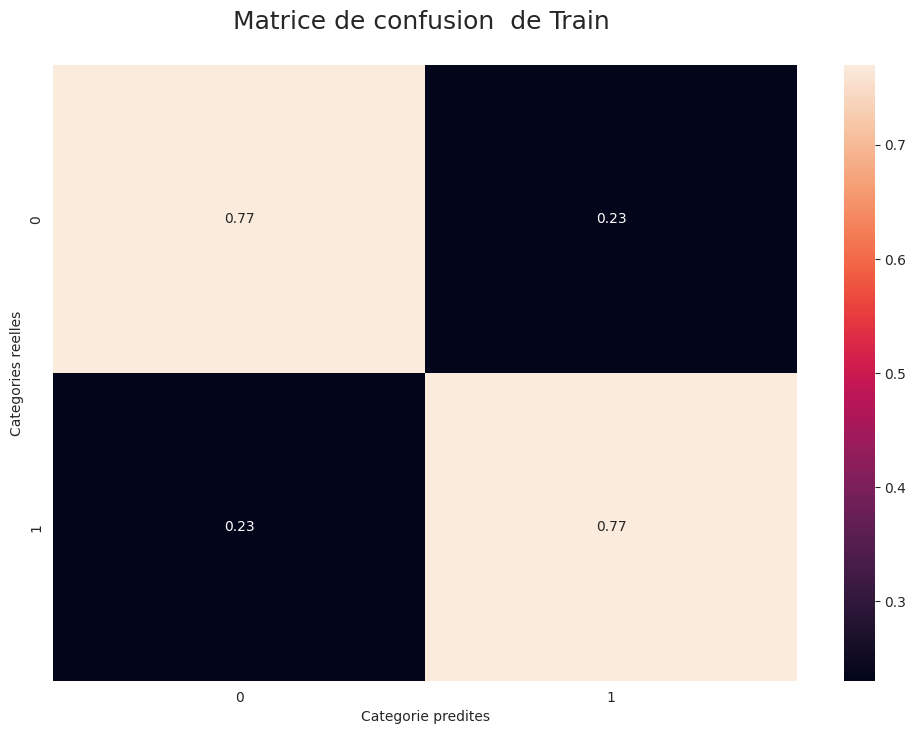

F2 score model 1 :  0.4205505982008724


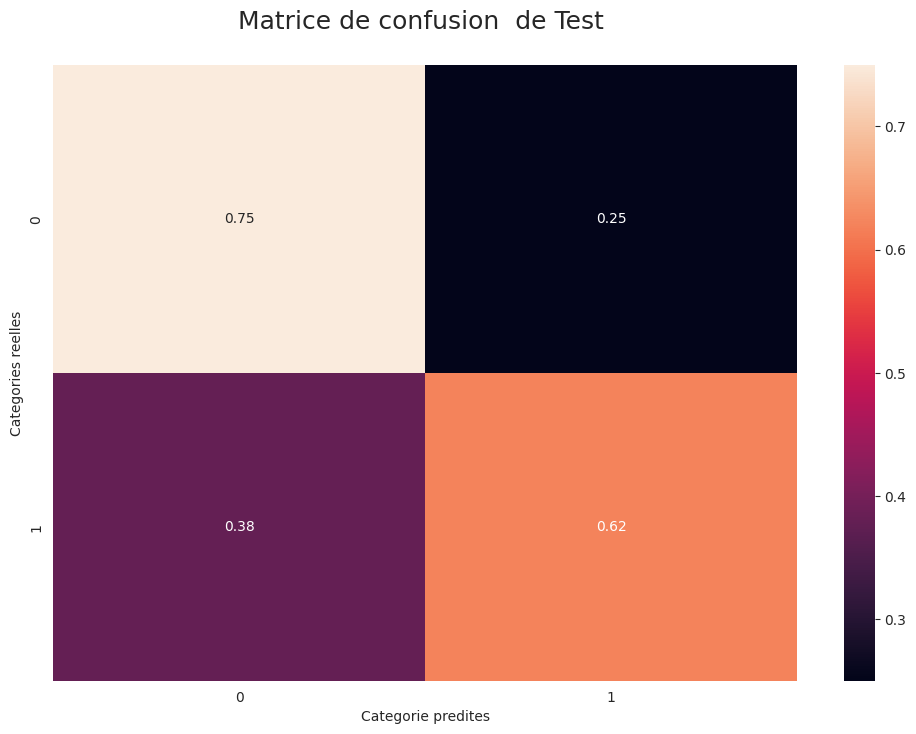

In [4]:
with mlflow.start_run():
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    mlflow.log_param("Feature Engineering", str(fe_filename))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

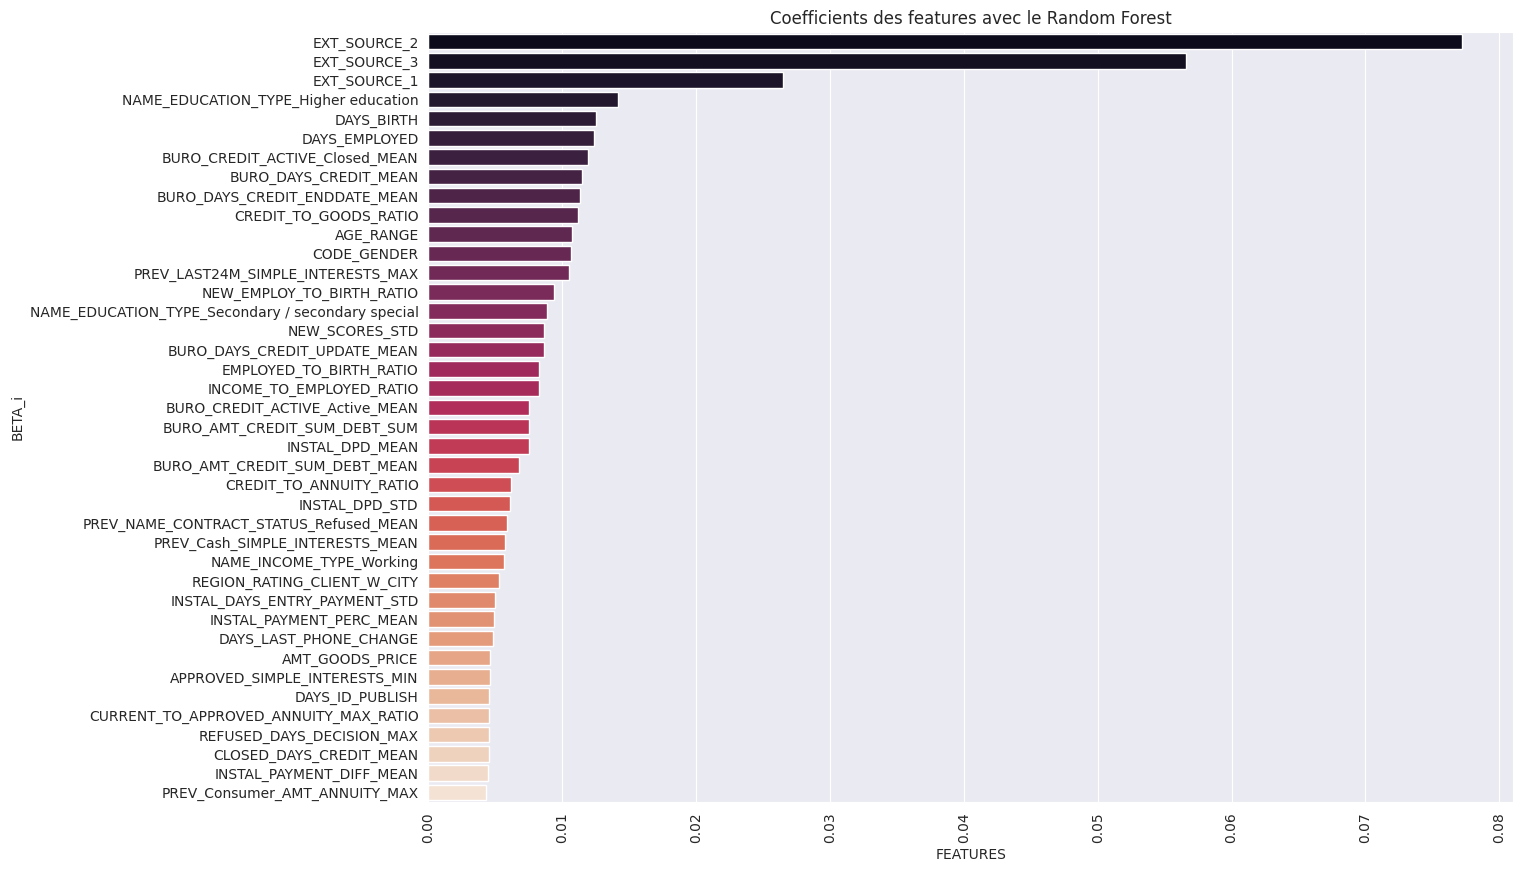

In [7]:
NB_TOP_FEATURES = 40
featimps = feature_importance_rf(xtrain=X_train, modelrf=model['estimator'], size=NB_TOP_FEATURES)

# FEATURE IMPORTANCE ANALYSIS BETWEEN MODELS

In [12]:
featimps.reset_index()

,index,feature,poids
0,20,EXT_SOURCE_2,0.077201
1,21,EXT_SOURCE_3,0.056616
2,19,EXT_SOURCE_1,0.026519
3,74,NAME_EDUCATION_TYPE_Higher education,0.014146
4,8,DAYS_BIRTH,0.012494
5,9,DAYS_EMPLOYED,0.012370
6,140,BURO_CREDIT_ACTIVE_Closed_MEAN,0.011950
7,118,BURO_DAYS_CREDIT_MEAN,0.011494
8,120,BURO_DAYS_CREDIT_ENDDATE_MEAN,0.011288
9,44,CREDIT_TO_GOODS_RATIO,0.011142


EXT_SOURCE 2 & 3 ont une importance nettement superieure a toutes les autres features. Meme EXT_SOURCE_1 est deux fois moins important que EXT_SOURCE_3

In [9]:
feat_imps_glob = pd.read_csv('./model_outputs/feature_importance.csv')

,feature,LogRegImportance
0,BURO_CREDIT_TYPE_Consumer credit_MEAN,1
1,BURO_CREDIT_TYPE_Credit card_MEAN,2
2,AMT_INCOME_TOTAL,3
3,BURO_CREDIT_TYPE_CREDIT_TYPE_divers_MEAN,4
4,INCOME_TO_BIRTH_RATIO,5
5,AMT_GOODS_PRICE,6
6,AMT_CREDIT,7
7,POS_SK_DPD_DEF_SUM,8
8,CC_LAST_AMT_BALANCE_MAX,9
9,EXT_SOURCE_2,10


In [20]:
print(featimps.dtypes)
print(feat_imps_glob.dtypes)

feature     object
poids      float64
dtype: object
feature             object
LogRegImportance     int64
dtype: object


In [29]:
feat_synthese = featimps.merge(feat_imps_glob, on = 'feature', how='outer')
feat_synthese.loc[:, 'RF_imp'] = feat_synthese.index + 1
feat_synthese.loc[feat_synthese['poids'].isna(), 'RF_imp'] = np.nan
feat_synthese.drop(columns = ['poids'], inplace=True)

In [26]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Sort the correlations with 'Target' in decreasing order
correlation_with_target = correlation_matrix['TARGET'].sort_values(ascending=False)

# Display the list of features most correlated to 'Target'
correlation_with_target

TARGET                           1.000000
INS_48M_LIMIT_USE_MEAN           0.135904
CC_LIMIT_USE_MEAN                0.135904
INS_12M_LIMIT_USE_MEAN           0.135904
INS_24M_LIMIT_USE_MEAN           0.135904
                                   ...   
EXT_SOURCE_3                    -0.178925
BURO_CREDIT_ACTIVE_nan_MEAN           NaN
BURO_CREDIT_CURRENCY_nan_MEAN         NaN
BURO_CREDIT_TYPE_nan_MEAN             NaN
BURO_STATUS_nan_MEAN_MEAN             NaN
Name: TARGET, Length: 534, dtype: float64

In [38]:
renamed_corr = correlation_with_target.reset_index().rename(columns = {'index' : 'feature'})

In [40]:
feat_synthese = feat_synthese.merge(renamed_corr, on='feature', how='left')
feat_synthese.rename(columns = {'TARGET' : 'corr_target'}, inplace=True)
feat_synthese

,feature,LogRegImportance,RF_imp,corr_target
0,EXT_SOURCE_2,10.0,1.0,-0.160471
1,EXT_SOURCE_3,11.0,2.0,-0.178925
2,EXT_SOURCE_1,NaN,3.0,-0.155318
3,NAME_EDUCATION_TYPE_Higher education,NaN,4.0,-0.056593
4,DAYS_BIRTH,40.0,5.0,0.078244
...,...,...,...,...
69,NAME_INCOME_TYPE_Pensioner,34.0,NaN,-0.046211
70,PREV_ACTIVE_DAYS_LAST_DUE_1ST_VERSION_MEAN,35.0,NaN,0.039755
71,ACTIVE_AMT_ANNUITY_MEAN,36.0,NaN,0.008562
72,INSTAL_COUNT,38.0,NaN,-0.021095


In [41]:
feat_synthese.loc[:, 'abs_corr_TGT'] = np.abs(feat_synthese['corr_target'])
feat_synthese

,feature,LogRegImportance,RF_imp,corr_target,abs_corr_TGT
0,EXT_SOURCE_2,10.0,1.0,-0.160471,0.160471
1,EXT_SOURCE_3,11.0,2.0,-0.178925,0.178925
2,EXT_SOURCE_1,NaN,3.0,-0.155318,0.155318
3,NAME_EDUCATION_TYPE_Higher education,NaN,4.0,-0.056593,0.056593
4,DAYS_BIRTH,40.0,5.0,0.078244,0.078244
...,...,...,...,...,...
69,NAME_INCOME_TYPE_Pensioner,34.0,NaN,-0.046211,0.046211
70,PREV_ACTIVE_DAYS_LAST_DUE_1ST_VERSION_MEAN,35.0,NaN,0.039755,0.039755
71,ACTIVE_AMT_ANNUITY_MEAN,36.0,NaN,0.008562,0.008562
72,INSTAL_COUNT,38.0,NaN,-0.021095,0.021095


In [42]:
feat_synthese.to_csv('./model_outputs/feature_importance.csv', index = False)

# NO EXT

In [45]:
fe_filename = 'kernel03_install_payments_Train_Only.csv'
df = pd.read_csv(INPUT_FOLDER+fe_filename)
df = ckk.reduce_memory(df)

X = df.drop(columns = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1','TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier(max_features='sqrt', class_weight='balanced', n_estimators=200)

# Parametres Random Forest
params = {
    'estimator__max_depth' : [20, None],
    'estimator__min_samples_split' : [100, 200, 500]
}

pipeline = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

Initial df memory usage is 1252.81 MB for 534 columns
Final memory usage is: 409.39 MB - decreased by 67.3%
X_train : (215254, 530) // X_test : (92253, 530)
y_train : (215254,) // y_test : (92253,)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=200))]),
             param_grid={'estimator__max_depth': [20, None],
                         'estimator__min_samples_split': [100, 200, 500]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [46]:
print("Best params : ", model.best_params_)
print("Best score : ", model.best_score_)

Best params :  {'estimator__max_depth': 20, 'estimator__min_samples_split': 200}
Best score :  0.39428359683795206


In [47]:
def grid_resultification(grid) :
    res = pd.DataFrame(grid.cv_results_)
    keepcols = [col for col in res.columns if "split" not in col]
    res = res[keepcols]
    # res = res.sort_values(by = ['rank_test_r2', 'rank_test_neg_mean_absolute_error'])
    return res

df_results_grid = grid_resultification(model)
df_results_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,73.025213,1.261661,2.045563,0.063835,20,"{'estimator__max_depth': 20, 'estimator__min_s...",0.388526,0.004839,5,0.571186,0.001774
1,65.608045,0.986699,1.706085,0.028980,20,"{'estimator__max_depth': 20, 'estimator__min_s...",0.394284,0.004324,1,0.495754,0.001991
2,54.447552,0.507121,1.205210,0.010776,20,"{'estimator__max_depth': 20, 'estimator__min_s...",0.392220,0.003474,4,0.435665,0.000923
3,74.504660,0.209086,2.046536,0.010412,None,"{'estimator__max_depth': None, 'estimator__min...",0.385347,0.004027,6,0.593215,0.002051
4,64.656521,0.573859,1.709567,0.032027,None,"{'estimator__max_depth': None, 'estimator__min...",0.392592,0.002206,3,0.499595,0.000818
5,53.291446,1.016028,1.191608,0.020374,None,"{'estimator__max_depth': None, 'estimator__min...",0.394188,0.002741,2,0.437082,0.000866


In [48]:
model = model.best_estimator_

 TRAIN F2 score model :  0.4933770249688466


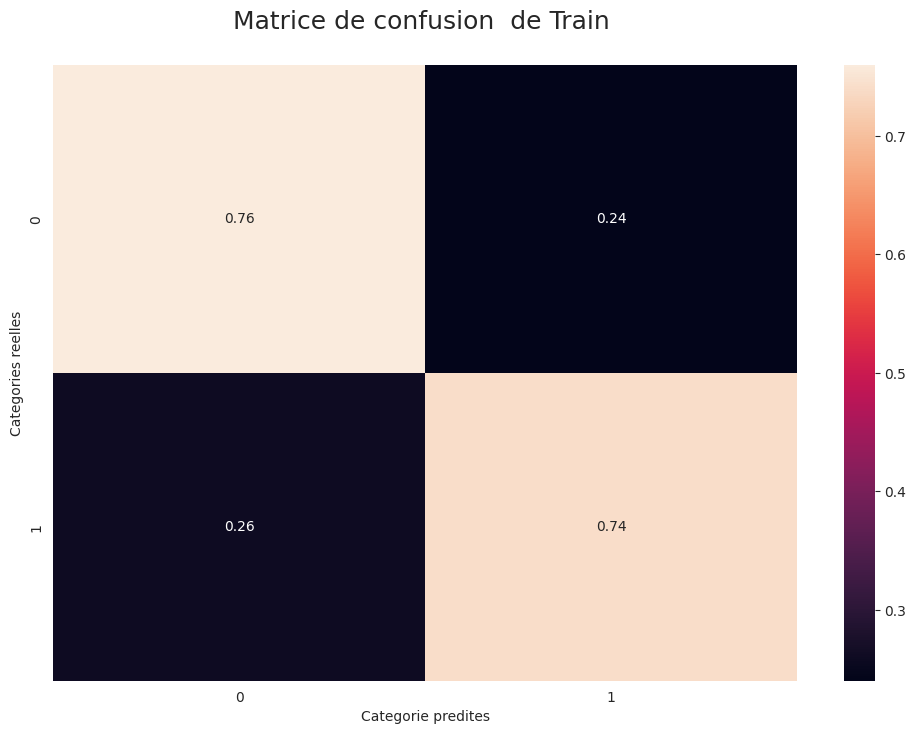

F2 score model 1 :  0.39605120807789396


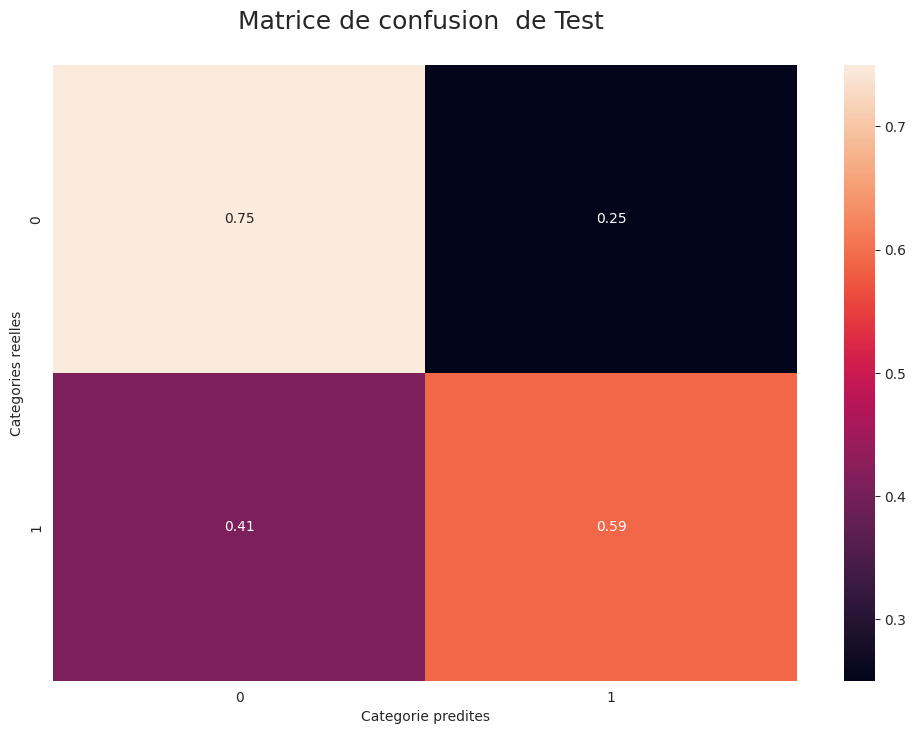

In [49]:
with mlflow.start_run():
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, "best_logreg_customKernels", signature=signature)

    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(estimator))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    mlflow.log_param("Feature Engineering", str(fe_filename))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

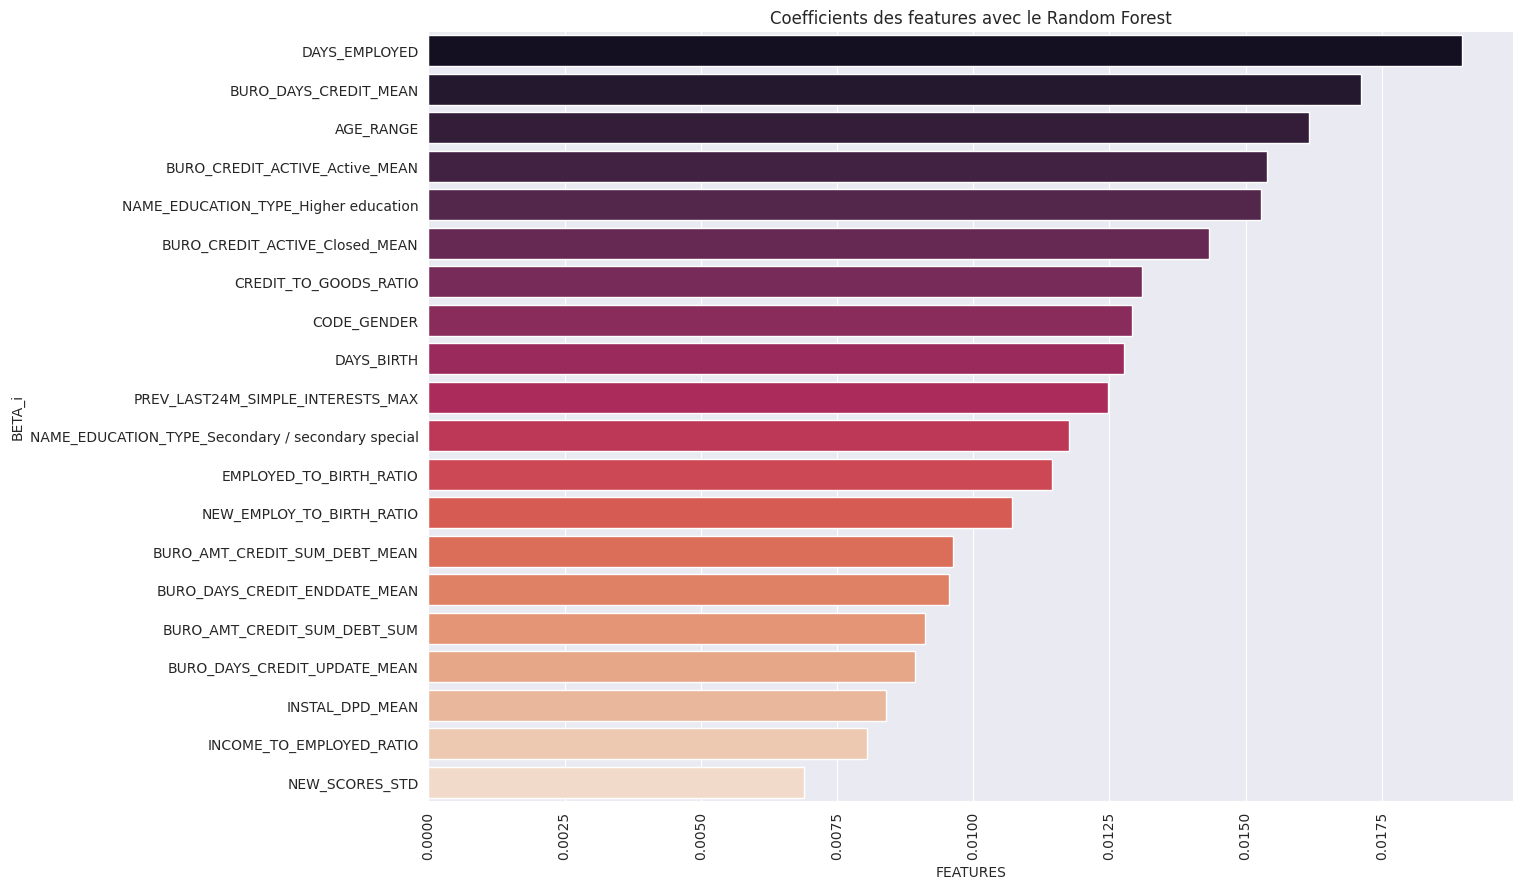

In [51]:
NB_TOP_FEATURES = 20
featimps = feature_importance_rf(xtrain=X_train, modelrf=model['estimator'], size=NB_TOP_FEATURES)

In [52]:
top20_feat = X[featimps['feature'].values.tolist()]
corr_top20 = top20_feat.corr()

In [54]:
corr_top20

,DAYS_EMPLOYED,BURO_DAYS_CREDIT_MEAN,AGE_RANGE,BURO_CREDIT_ACTIVE_Active_MEAN,NAME_EDUCATION_TYPE_Higher education,BURO_CREDIT_ACTIVE_Closed_MEAN,CREDIT_TO_GOODS_RATIO,CODE_GENDER,DAYS_BIRTH,PREV_LAST24M_SIMPLE_INTERESTS_MAX,NAME_EDUCATION_TYPE_Secondary / secondary special,EMPLOYED_TO_BIRTH_RATIO,NEW_EMPLOY_TO_BIRTH_RATIO,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_DAYS_CREDIT_UPDATE_MEAN,INSTAL_DPD_MEAN,INCOME_TO_EMPLOYED_RATIO,NEW_SCORES_STD
DAYS_EMPLOYED,1.000000,0.159997,-0.330845,0.076310,0.003651,-0.076913,0.013313,-0.092562,0.352308,0.093430,-0.031156,-0.954679,-0.954679,0.010070,0.070194,-0.030267,0.100414,-0.009460,-0.177837,0.038316
BURO_DAYS_CREDIT_MEAN,0.159997,1.000000,-0.202910,0.500322,-0.012493,-0.493011,0.011692,0.000638,0.203134,0.107522,-0.007666,-0.125378,-0.125378,0.097168,0.279159,0.040032,0.758022,-0.013801,-0.020123,0.013376
AGE_RANGE,-0.330845,-0.202910,1.000000,-0.114834,-0.106632,0.114362,0.013370,0.141031,-0.952577,-0.142891,0.149668,0.129525,0.129525,-0.074403,-0.143295,-0.069550,-0.158824,0.009277,0.041741,-0.029319
BURO_CREDIT_ACTIVE_Active_MEAN,0.076310,0.500322,-0.114834,1.000000,0.013578,-0.992232,0.032662,-0.018268,0.116115,0.053243,-0.025853,-0.063496,-0.063496,0.204035,0.323597,0.110716,0.558121,-0.004564,-0.016725,0.017775
NAME_EDUCATION_TYPE_Higher education,0.003651,-0.012493,-0.106632,0.013578,1.000000,-0.013477,-0.086723,0.016032,0.115805,-0.076122,-0.888007,0.013407,0.013407,0.081780,0.032191,0.116382,0.023915,-0.007793,-0.033819,-0.012919
BURO_CREDIT_ACTIVE_Closed_MEAN,-0.076913,-0.493011,0.114362,-0.992232,-0.013477,1.000000,-0.032545,0.018976,-0.115924,-0.054774,0.025857,0.064341,0.064341,-0.204904,-0.321488,-0.110708,-0.553694,0.004154,0.016730,-0.019293
CREDIT_TO_GOODS_RATIO,0.013313,0.011692,0.013370,0.032662,-0.086723,-0.032545,1.000000,0.002607,-0.012271,0.060170,0.083580,-0.019293,-0.019293,-0.010285,-0.001211,-0.017888,0.008436,0.007542,0.003957,0.020782
CODE_GENDER,-0.092562,0.000638,0.141031,-0.018268,0.016032,0.018976,0.002607,1.000000,-0.148066,-0.070096,-0.004715,0.080747,0.080747,-0.058223,-0.032251,-0.062889,-0.031422,-0.001200,0.046278,-0.031706
DAYS_BIRTH,0.352308,0.203134,-0.952577,0.116115,0.115805,-0.115924,-0.012271,-0.148066,1.000000,0.150695,-0.157378,-0.137907,-0.137907,0.079839,0.149201,0.076635,0.160958,-0.008736,-0.043791,0.028727
PREV_LAST24M_SIMPLE_INTERESTS_MAX,0.093430,0.107522,-0.142891,0.053243,-0.076122,-0.054774,0.060170,-0.070096,0.150695,1.000000,0.063879,-0.067965,-0.067965,-0.015112,0.050330,-0.016233,0.070806,0.006835,-0.001596,0.031259


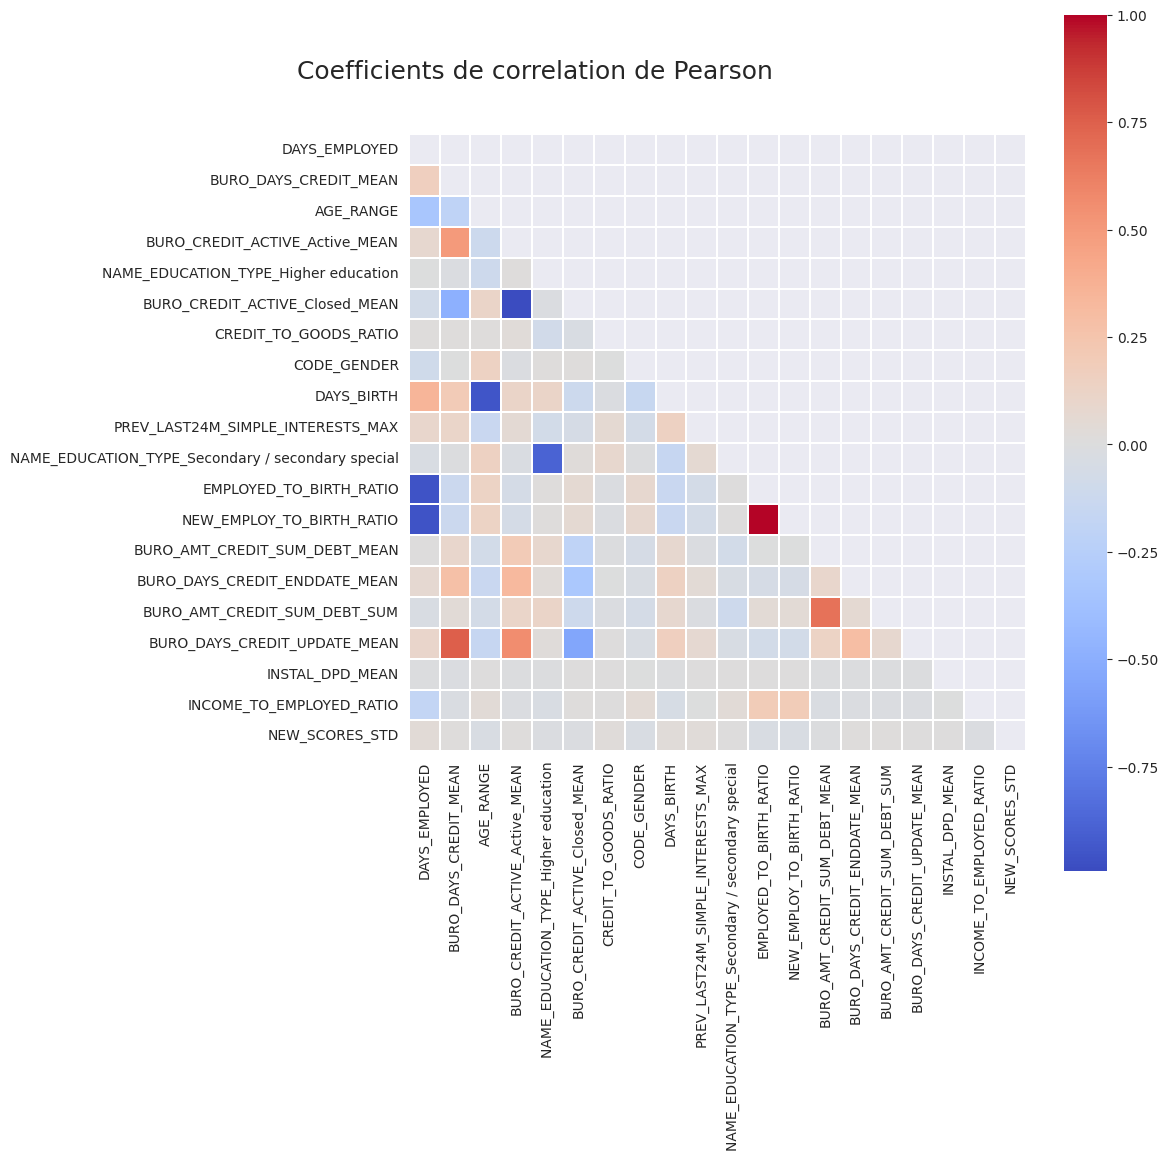

In [55]:
# Mask for upper triangle
mask = np.triu(np.ones_like(corr_top20, dtype=bool))

# size of the plot
f, ax = plt.subplots(figsize=(12, 12))
# set the plot heading
f.text(0.45, 0.93, "Coefficients de correlation de Pearson", ha='center', fontsize = 18)
# plot matrix as a heatmap
sns.heatmap(corr_top20, mask=mask, square=True, linewidths=0.01, cmap="coolwarm")
plt.tight_layout()